# Package initiation

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import shutil
import random
import pprint
import itertools
import functools
import collections

import pysam
import pyranges as pr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import scipy.stats
# import sklearn.cluster

import sys
# sys.path.remove('/home/users/pjh/scripts/python_genome_packages')
sys.path.append('/home/users/pjh/scripts/python_genome_package_dev')

In [19]:
from handygenome import common
from handygenome.common import ChromDict, Interval
from handygenome.variant.vcfspec import Vcfspec

from handygenome.sv.breakends import Breakends
from handygenome.variant.variantplus import VariantPlus, VariantPlusList
import handygenome.variant.variantplus as libvp
# from handygenome.variant.vcfplus import VcfPlus
from handygenome.igvhandle import IGVHandle

from handygenome.variant import vpfilter as libvpfilter
from handygenome.vcfeditor.initvcf import create_header

In [3]:
FASTA_PATH_HG19 = "/home/users/data/01_reference/human_g1k_v37/human_g1k_v37.fasta"
FASTA_PATH_HG38 = "/home/users/data/01_reference/human_g1k_v38/Homo_sapiens_assembly38.fasta"

FASTA_HG19 = pysam.FastaFile(FASTA_PATH_HG19)
FASTA_HG38 = pysam.FastaFile(FASTA_PATH_HG38)
CHROMDICT_HG19 = ChromDict(fasta_path=FASTA_PATH_HG19)
CHROMDICT_HG38 = ChromDict(fasta_path=FASTA_PATH_HG38)

# Basic setups

In [4]:
SAMPLEIDS = [
    '14', '6', '87', 'F13', 'F2', 'F33', 'F37', 'FF1', 'FF104', 'FF115', 'FF13', 'FF18', 'FF20', 'FF21', 'FF23', 'FF24', 'FF27', 
    'FF3', 'FF31', 'FF34', 'FF37', 'FF39', 'FF4', 'FF43', 'FF53', 'FF56', 'FF57', 'FF58', 'FF6', 'FF62', 'FF67', 'FF71', 'FF76', 
    'FF77', 'FF78', 'FF79', 'FF80', 'FF85', 
    #'IO04',  # swapped sample
    'IO05', 'IO06', 'IO07', 'IO08', 'IO09', 'IO12', 'IO13', 'IO15', 'IO16', 'IO17', 
    'IO18', 'IO22', 'IO23', 'IO24', 'IO25', 'SC126', 'SC134', 'SC31', 'SC81', 'SC88', 'SC97', 'SC98', 
]
SAMPLEIDS_LU = [f'LU-{x}' for x in SAMPLEIDS]
SAMPLEIDS_LU_PANEL = [f'{x}_panel' for x in SAMPLEIDS_LU]
SAMPLEIDS_LU_TUMOR = [f'{x}_tumor' for x in SAMPLEIDS_LU]

BAM_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/02_BAM/'
PANEL_REGION_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/exon_intron_targetregions_merged.bed'
PANEL_REGION_EXONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_exon_Regions_tracknamechanged.bed'
PANEL_REGION_INTRONS_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/panel_bait_design/custom/SNUH_FIRST_Lung_Cancer_V5_intron_Regions_tracknamechanged.bed'
WGS_TMB_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/metadata/wgs_TMB_previously_found_210312.txt'

In [5]:
sampletype_filename_map = {
    'tumor': ['tumor'], 
    'normal': ['normal'], 
    'panel': ['panel'], 
    'rna': ['RNA', 'RNA_GFP'],
}
BAM_PATHS = {sampletype: dict() for sampletype in sampletype_filename_map.keys()}

for top, dirs, files in os.walk(BAM_TOPDIR):
    for f in files:
        for sampleid in SAMPLEIDS_LU:
            for sampletype, fname_portions in sampletype_filename_map.items():
                if f in (f'{sampleid}.{fname_portion}.bam' for fname_portion in fname_portions):
                    BAM_PATHS[sampletype][sampleid] = os.path.join(top, f)

In [6]:
BAMS = {
    sampletype: {
        sampleid: pysam.AlignmentFile(bampath) 
        for sampleid, bampath in bampathdic.items()
    }
    for sampletype, bampathdic in BAM_PATHS.items()
}



In [1]:
_sampleid_keys = ['LU-14', 'LU-6', 'LU-87', 'LU-F13', 'LU-F2', 'LU-F33', 'LU-F37', 'LU-FF1', 'LU-FF104', 'LU-FF115', 'LU-FF13', 'LU-FF18', 'LU-FF20', 'LU-FF21', 'LU-FF23', 'LU-FF24', 'LU-FF27', 'LU-FF3', 'LU-FF31', 'LU-FF34', 'LU-FF37', 'LU-FF39', 'LU-FF4', 'LU-FF43', 'LU-FF53', 'LU-FF56', 'LU-FF57', 'LU-FF58', 'LU-FF6', 'LU-FF62', 'LU-FF67', 'LU-FF71', 'LU-FF76', 'LU-FF77', 'LU-FF78', 'LU-FF79', 'LU-FF80', 'LU-FF85', 'LU-IO04', 'LU-IO05', 'LU-IO06', 'LU-IO07', 'LU-IO08', 'LU-IO09', 'LU-IO12', 'LU-IO13', 'LU-IO15', 'LU-IO16', 'LU-IO17', 'LU-IO18', 'LU-IO22', 'LU-IO23', 'LU-IO24', 'LU-IO25', 'LU-SC126', 'LU-SC134', 'LU-SC31', 'LU-SC81', 'LU-SC88', 'LU-SC97', 'LU-SC98',]

PREVIOUS_PURITY = dict(zip(
    _sampleid_keys,
    [0.31, 0.16, 0.24, 0.75, 0.28, 0.5, 0.34, 0.17, 0.45, 0.43, 0.21, 0.86, 0.32, 0.37, 0.35, 0.5, 0.48, 0.2, 0.11, 0.19, 0.75, 0.21, 0.15, 0.34, 0.33, 0.37, 0.21, 0.14, 0.47, 0.52, 0.28, 0.11, 0.54, 0.27, 0.36, 0.36, 0.28, 0.24, 0.1, 0.36, 0.23, 0.24, 0.65, 0.31, 0.49, 0.69, 0.41, 0.32, 0.5, 0.42, 0.57, 0.11, 0.2, 0.28, 0.11, 0.4, 0.22, 0.4, 0.13, 0.15, 0.51,],
))

PREVIOUS_PLOIDY = dict(zip(
    _sampleid_keys,
    [2.6, 2.3, 2.7, 2.4, 1.9, 4.8, 1.9, 2.7, 2, 1.9, 2.9, 2.6, 4.5, 2.9, 2.8, 3.6, 2.1, 2.5, 2.3, 2, 2.4, 2, 2.6, 4.1, 5.7, 2.7, 3.45, 2.3, 2.1, 3.5, 2.2, 2.3, 2, 2.2, 2.9, 2, 2.2, 2.8, 2.1, 2.7, 2.4, 4.5, 2.3, 3.1, 3.5, 3.5, 5.3, 1.9, 3.3, 2.1, 2.9, 1.8, 4.4, 3.3, 2.4, 3.1, 3.7, 3.3, 1.6, 2.5, 1.9,],
))

MEAN_DEPTH_WGS_NORMAL = dict(zip(
    _sampleid_keys,
    [37.3767, 34.0972, 33.8064, 32.7928, 35.8954, 50.7577, 35.2345, 44.4876, 31.9701, 32.5393, 29.2703, 35.8483, 30.652, 30.3674, 30.7484, 37.0206, 32.9964, 32.02, 44.0783, 31.1997, 35.246, 25.3979, 27.8882, 32.5782, 32.0687, 29.2798, 35.0811, 31.21, 31.6326, 30.6922, 34.1979, 36.7596, 46.6577, 31.1763, 33.2672, 30.7369, 49.3219, 39.396, 50.6684, 47.5066, 42.1341, 50.5406, 61.0353, 48.3776, 47.3945, 47.8588, 53.5356, 50.1395, 51.1773, 48.859, 62.2889, 48.3631, 50.9241, 49.4595, 38.866, 48.8294, 60.0835, 39.58, 48.9517, 38.0445, 50.1143, ],
))

MEAN_DEPTH_WGS_TUMOR = dict(zip(
    _sampleid_keys,
    [33.8314, 28.6972, 39.9078, 31.2967, 35.1856, 50.3825, 32.995, 44.5512, 43.6843, 37.4389, 44.6266, 51.0667, 45.7373, 49.1081, 48.7203, 44.3134, 39.4903, 43.6447, 43.191, 46.8438, 32.9415, 43.3598, 47.5503, 48.4404, 47.5455, 42.8442, 36.943, 30.8365, 46.2036, 45.757, 46.2073, 41.2358, 32.9015, 38.2982, 37.7461, 35.5173, 47.0067, 50.212, 47.7919, 49.4914, 40.2729, 48.2904, 48.8819, 49.3573, 48.2809, 48.1625, 46.9765, 48.5246, 47.191, 57.4008, 45.9216, 61.224, 58.4995, 54.2237, 39.9667, 46.8006, 46.7105, 29.9816, 46.1059, 35.9943, 59.4945,],
))

MEAN_DEPTH_PANEL = dict(zip(
    _sampleid_keys,
    [925.555, 828.655, 1056.57, 949.034, 658.752, 943.504, 865.002, 1005.13, 1017.37, 928.113, 704.835, 1038.69, 841.098, 796.267, 861.94, 1199.86, 982.991, 622.94, 755.689, 883.229, 763.161, 994.175, 832.632, 886.978, 870.606, 940.946, 1123.63, 973.926, 867.741, 930.398, 983.845, 933.354, 992.087, 1019.04, 1027.85, 875.693, 860.521, 864.663, 934.823, 894.882, 1150.48, 866.108, 1018.39, 961.328, 1079.97, 792.767, 793.318, 362.512, 858.098, 1006.79, 1154.51, 837.199, 786.832, 1094.11, 689.674, 798.415, 1001.33, 1079.07, 760.339, 761.318, 880.314, ],
))

PANEL_ONTARGET_RATIO = dict(zip(
    _sampleid_keys,
    [0.911, 0.872, 0.79, 0.917, 0.838, 0.761, 0.701, 0.934, 0.924, 0.913, 0.696, 0.718, 0.85, 0.905, 0.87, 0.899, 0.879, 0.66, 0.783, 0.885, 0.761, 0.912, 0.789, 0.868, 0.63, 0.74, 0.808, 0.835, 0.891, 0.698, 0.914, 0.925, 0.922, 0.91, 0.923, 0.86, 0.822, 0.795, 0.758, 0.834, 0.88, 0.926, 0.924, 0.895, 0.869, 0.842, 0.72, 0.838, 0.798, 0.871, 0.91, 0.872, 0.826, 0.904, 0.858, 0.84, 0.881, 0.929, 0.806, 0.831, 0.867, ],
))

GENDER = dict(zip(
    _sampleid_keys,
    ['M', 'F', 'F', 'F', 'M', 'F', 'M', 'M', 'F', 'F', 'M', 'M', 'F', 'F', 'F', 'F', 'M', 'F', 'F', 'M', 'F', 'M', 'F', 'F', 'M', 'M', 'F', 'M', 'M', 'M', 'F', 'M', 'F', 'F', 'F', 'M', 'M', 'M', 'F', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'M', 'M', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'F', 'M',]
))
IS_FEMALE = {key: (val == 'F') for key, val in GENDER.items()}

In [8]:
PANEL_REGION_GR = pr.read_bed(PANEL_REGION_PATH)

In [9]:
WHOLE_GENOME_LENGTH = 3_095_677_412
PANEL_REGION_LENGTH = 1_890_272

In [10]:
igv = IGVHandle(60387)

# Setup convenience functions

#### show_vp functions

In [11]:
def load_bams(sampleid, load_rna=False):
    igv.cmd('new')
    if load_rna:
        igv.load([
            BAM_PATHS['normal'][sampleid], 
            BAM_PATHS['tumor'][sampleid], 
            BAM_PATHS['panel'][sampleid],
            BAM_PATHS['rna'][sampleid],
        ])
    else:
        igv.load([
            BAM_PATHS['normal'][sampleid], 
            BAM_PATHS['tumor'][sampleid], 
            BAM_PATHS['panel'][sampleid],
        ])        

In [12]:
def show_vp_igv(vp, sampleid):
    igv.cmd('new')
    igv.load([PANEL_REGION_PATH, PANEL_REGION_EXONS_PATH, PANEL_REGION_INTRONS_PATH])
    load_bams(sampleid)

    igv.goto([vp.vcfspec], width=200)
    igv.cmd('viewaspairs')
    igv.cmd('sort base')

#### others

In [13]:
def sypark_vcf_iterator(vcf_path):
    for linedict in common.fileiter(vcf_path, sep='\t'):
        linedict['POS'] = int(linedict['POS'])
        yield linedict

In [14]:
from handygenome.annotation import readstats as libreadstats

def make_readstats(vcfspec, sampleid, sampletype):
    bam = BAMS[sampletype][sampleid]
    readstats = libreadstats.get_readstats(vcfspec, bam, FASTA_HG19, CHROMDICT_HG19)
    return readstats

#### for calculating the distance from the nearest bait end 

In [15]:
def get_bait_end_distance(vp):
    ovlp_bait_gr = PANEL_REGION_GR.overlap(vp.get_gr())
    distance = min(abs(vp.vr.start - ovlp_bait_gr.Start[0]),
                   abs(vp.vr.start - (ovlp_bait_gr.End[0] - 1)))
    
    return distance

# Convert previous wgs analysis results into VCF

#### Set previous wgs vcf paths - snv

In [14]:
SYPARK_VCF_PATHS = dict()

SYPARK_VCF_TOPDIR = '/home/users/sypark/00_Project/05_Rearrangement/19_revision_total_samples/01_snv'
for fname in os.listdir(SYPARK_VCF_TOPDIR):
    if fname.startswith('LU-'):
        sampleid = fname.split('.')[0]
        if sampleid in SAMPLEIDS_LU:
            SYPARK_VCF_PATHS[sampleid] = os.path.join(SYPARK_VCF_TOPDIR, fname)
            
SYPARK_VCF_TOPDIR2 = '/home/users/sypark/00_Project/05_Rearrangement/19_revision_total_samples/01_snv/deprecated/'
for fname in os.listdir(SYPARK_VCF_TOPDIR2):
    if fname.startswith('LU-'):
        sampleid = fname.split('.')[0]
        if sampleid in SAMPLEIDS_LU and sampleid not in SYPARK_VCF_PATHS.keys():
            SYPARK_VCF_PATHS[sampleid] = os.path.join(SYPARK_VCF_TOPDIR2, fname)
            
IO_VCF_PATHS = dict()
IO_VCF_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/links_other_projects/LungCancer_IO_WGS/01_WGS/07_pointMT/01_snv'
# sampleids_io_modified = ['SNU_LC_IO_' + re.sub('LU-IO', '', x)
#                          for x in SAMPLEIDS_LU 
#                          if x.startswith('LU-IO')]
alias_dict = {'LU-IO02': 'LU-F33',
              'LU-IO14': 'LU-FF80',
              'LU-IO21': 'LU-SC134',
              'LU-IO01': 'LU-SC31',
              'LU-IO19': 'LU-SC88',
              'LU-IO20': 'LU-SC98',
              }
for fname in os.listdir(IO_VCF_TOPDIR):
    if fname.endswith('.anv.occ.fi'):
        sampleid = 'LU-IO' + fname.split('.')[0].split('_')[-1]
        if sampleid in alias_dict:
            sampleid = alias_dict[sampleid]
            
        if sampleid in SAMPLEIDS_LU:
            IO_VCF_PATHS[sampleid] = os.path.join(IO_VCF_TOPDIR, fname)

PREVIOUS_VCF_PATHS = dict()
PREVIOUS_VCF_PATHS.update(SYPARK_VCF_PATHS)
PREVIOUS_VCF_PATHS.update(IO_VCF_PATHS)

PREVIOUS_VCF_PATHS_SNV = PREVIOUS_VCF_PATHS

#### Set previous wgs vcf paths - indel

In [15]:
SYPARK_VCF_PATHS = dict()

SYPARK_VCF_TOPDIR = '/home/users/sypark/00_Project/05_Rearrangement/19_revision_total_samples/03_indel/final'
for fname in os.listdir(SYPARK_VCF_TOPDIR):
    if fname.startswith('LU-') and fname.endswith('.fi'):
        sampleid = fname.split('.')[0]
        if sampleid in SAMPLEIDS_LU:
            SYPARK_VCF_PATHS[sampleid] = os.path.join(SYPARK_VCF_TOPDIR, fname)            

SYPARK_VCF_TOPDIR2 = '/home/users/sypark/00_Project/05_Rearrangement/19_revision_total_samples/03_indel/final/deprecated'
for fname in os.listdir(SYPARK_VCF_TOPDIR2):
    if fname.startswith('LU-'):
        sampleid = fname.split('.')[0]
        if sampleid in SAMPLEIDS_LU and sampleid not in SYPARK_VCF_PATHS.keys():
            SYPARK_VCF_PATHS[sampleid] = os.path.join(SYPARK_VCF_TOPDIR2, fname)

IO_VCF_PATHS = dict()
IO_VCF_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/links_other_projects/LungCancer_IO_WGS/01_WGS/07_pointMT/02_indel'
alias_dict = {'LU-IO02': 'LU-F33',
              'LU-IO14': 'LU-FF80',
              'LU-IO21': 'LU-SC134',
              'LU-IO01': 'LU-SC31',
              'LU-IO19': 'LU-SC88',
              'LU-IO20': 'LU-SC98',
              }
for fname in os.listdir(IO_VCF_TOPDIR):
    if fname.endswith('.anv.occ.fi'):
        sampleid = 'LU-IO' + fname.split('.')[0].split('_')[-1]
        if sampleid in alias_dict:
            sampleid = alias_dict[sampleid]
            
        if sampleid in SAMPLEIDS_LU:
            IO_VCF_PATHS[sampleid] = os.path.join(IO_VCF_TOPDIR, fname)

PREVIOUS_VCF_PATHS = dict()
PREVIOUS_VCF_PATHS.update(SYPARK_VCF_PATHS)
PREVIOUS_VCF_PATHS.update(IO_VCF_PATHS)

PREVIOUS_VCF_PATHS_INDEL = PREVIOUS_VCF_PATHS

#### Write previous files into VCFs

In [100]:
from handygenome.variantplus.varianthandler import apply_vcfspec

def prev_wgs_to_vcf(prev_file_path, new_path):
    vcfspec_list = list()
    hdr = create_header(chromdict=CHROMDICT_HG19)
    with pysam.VariantFile(new_path, mode='wz', header=hdr) as out_vcf:
        for linedict in sypark_vcf_iterator(prev_file_path):
            for alt in linedict['ALT'].split(','):            
                vcfspec = Vcfspec(chrom=linedict['CHROM'], pos=linedict['POS'], ref=linedict['REF'], alts=(alt,))
                vcfspec_list.append(vcfspec)
                
        for vcfspec in sorted(vcfspec_list, key=common.get_vcfspec_sortkey(CHROMDICT_HG19)):
            vr = out_vcf.header.new_record()
            apply_vcfspec(vr, vcfspec)
            out_vcf.write(vr)

In [101]:
previous_wgs_vcf_dir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/previous_wgs_results'

for sampleid in SAMPLEIDS_LU:
    print(sampleid)
    
    new_path_snv = os.path.join(previous_wgs_vcf_dir, f'{sampleid}.snv.vcf.gz')
    prev_wgs_to_vcf(PREVIOUS_VCF_PATHS_SNV[sampleid], new_path_snv)
    
    new_path_indel = os.path.join(previous_wgs_vcf_dir, f'{sampleid}.indel.vcf.gz')
    prev_wgs_to_vcf(PREVIOUS_VCF_PATHS_INDEL[sampleid], new_path_indel)

LU-14
LU-6
LU-87
LU-F13
LU-F2
LU-F33
LU-F37
LU-FF1
LU-FF104
LU-FF115
LU-FF13
LU-FF18
LU-FF20
LU-FF21
LU-FF23
LU-FF24
LU-FF27
LU-FF3
LU-FF31
LU-FF34
LU-FF37
LU-FF39
LU-FF4
LU-FF43
LU-FF53
LU-FF56
LU-FF57
LU-FF58
LU-FF6
LU-FF62
LU-FF67
LU-FF71
LU-FF76
LU-FF77
LU-FF78
LU-FF79
LU-FF80
LU-FF85
LU-IO04
LU-IO05
LU-IO06
LU-IO07
LU-IO08
LU-IO09
LU-IO12
LU-IO13
LU-IO15
LU-IO16
LU-IO17
LU-IO18
LU-IO22
LU-IO23
LU-IO24
LU-IO25
LU-SC126
LU-SC134
LU-SC31
LU-SC81
LU-SC88
LU-SC97
LU-SC98


# Load newly annotated previous wgs vcf files

In [16]:
# PREVIOUS_WGS_REANNOT_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/previous_wgs_results/feature_annot_220810'
PREVIOUS_WGS_REANNOT_TOPDIR = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/previous_wgs_results/reannot_220914/'
PREVIOUS_WGS_REANNOT_VCF_PATHS_SNV = dict()
PREVIOUS_WGS_REANNOT_VCF_PATHS_INDEL = dict()

for fname in os.listdir(PREVIOUS_WGS_REANNOT_TOPDIR):
    if fname.endswith('.annot.readstats.vcf.gz'):
        sampleid = fname.split('.')[0]
        if 'snv' in fname:
            PREVIOUS_WGS_REANNOT_VCF_PATHS_SNV[sampleid] = os.path.join(PREVIOUS_WGS_REANNOT_TOPDIR, fname)
        elif 'indel' in fname:
            PREVIOUS_WGS_REANNOT_VCF_PATHS_INDEL[sampleid] = os.path.join(PREVIOUS_WGS_REANNOT_TOPDIR, fname)

In [60]:
vplist = libvp.load_vcf(PREVIOUS_WGS_REANNOT_VCF_PATHS_SNV['LU-14'])

In [61]:
vplist.filter(lambda vp: vp.transcript[0].is_protein_altering)

<VariantPlusList of length 11 [
	0	<VariantPlus(chrom=2, pos=169989185, ref=C, alts=('G',), gene=alt_index 0: LRP2:p.Val4543Leu)>
	1	<VariantPlus(chrom=4, pos=22748960, ref=A, alts=('C',), gene=alt_index 0: GBA3:p.Asn110His)>
	2	<VariantPlus(chrom=5, pos=155771593, ref=G, alts=('A',), gene=alt_index 0: SGCD:p.Arg33Gln)>
	3	<VariantPlus(chrom=6, pos=108502064, ref=A, alts=('G',), gene=alt_index 0: NR2E1:p.Ile265Val)>
	4	<VariantPlus(chrom=7, pos=134644845, ref=G, alts=('A',), gene=alt_index 0: CALD1:p.Ala728Thr)>
	5	<VariantPlus(chrom=10, pos=26994285, ref=T, alts=('A',), gene=alt_index 0: PDSS1:p.Trp100Arg)>
	6	<VariantPlus(chrom=13, pos=100517084, ref=G, alts=('C',), gene=alt_index 0: CLYBL:p.Glu185Gln)>
	7	<VariantPlus(chrom=14, pos=89817020, ref=G, alts=('A',), gene=alt_index 0: FOXN3:p.Gln226Ter, RP11-356K23.1:n.209+183G>A)>
	8	<VariantPlus(chrom=14, pos=102356602, ref=G, alts=('A',), gene=alt_index 0: PPP2R5C:p.Gly251Ser)>
	9	<VariantPlus(chrom=15, pos=71055700, ref=G, alts=('A',)

In [65]:
tmpfile_path = '/home/users/pjh/tmp/vplist_teste.vcf.gz'
vplist.filter(lambda vp: vp.transcript[0].is_protein_altering).write(tmpfile_path)

In [483]:
PREVIOUS_WGS_REANNOT_VCF_SNV = dict()
PREVIOUS_WGS_REANNOT_VCF_INDEL = dict()

for key, val in PREVIOUS_WGS_REANNOT_VCF_PATHS_SNV.items():
    print(key)
    PREVIOUS_WGS_REANNOT_VCF_SNV[key] = VcfPlus(val, logging_lineno=3000)

for key, val in PREVIOUS_WGS_REANNOT_VCF_PATHS_INDEL.items():
    print(key)
    PREVIOUS_WGS_REANNOT_VCF_INDEL[key] = VcfPlus(val, logging_lineno=3000)

LU-IO18


[KST 2022-11-04 08:11:13 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:11:17 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:11:22 INFO] handygenome.variant.vcfplus: Processing 9,000th line


LU-F13


[KST 2022-11-04 08:11:29 INFO] handygenome.variant.vcfplus: Processing 3,000th line


LU-FF71
LU-IO16


[KST 2022-11-04 08:11:35 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:11:39 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:11:42 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:11:46 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:11:50 INFO] handygenome.variant.vcfplus: Processing 15,000th line
[KST 2022-11-04 08:11:54 INFO] handygenome.variant.vcfplus: Processing 18,000th line
[KST 2022-11-04 08:11:58 INFO] handygenome.variant.vcfplus: Processing 21,000th line


LU-IO25


[KST 2022-11-04 08:12:04 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:12:08 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:12:13 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:12:17 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:12:21 INFO] handygenome.variant.vcfplus: Processing 15,000th line
[KST 2022-11-04 08:12:25 INFO] handygenome.variant.vcfplus: Processing 18,000th line
[KST 2022-11-04 08:12:30 INFO] handygenome.variant.vcfplus: Processing 21,000th line
[KST 2022-11-04 08:12:34 INFO] handygenome.variant.vcfplus: Processing 24,000th line
[KST 2022-11-04 08:12:39 INFO] handygenome.variant.vcfplus: Processing 27,000th line


LU-IO15


[KST 2022-11-04 08:12:48 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:12:52 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:12:56 INFO] handygenome.variant.vcfplus: Processing 9,000th line


LU-F33


[KST 2022-11-04 08:13:03 INFO] handygenome.variant.vcfplus: Processing 3,000th line


LU-IO23


[KST 2022-11-04 08:13:11 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:13:15 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:13:19 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:13:23 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:13:27 INFO] handygenome.variant.vcfplus: Processing 15,000th line
[KST 2022-11-04 08:13:31 INFO] handygenome.variant.vcfplus: Processing 18,000th line
[KST 2022-11-04 08:13:35 INFO] handygenome.variant.vcfplus: Processing 21,000th line
[KST 2022-11-04 08:13:39 INFO] handygenome.variant.vcfplus: Processing 24,000th line
[KST 2022-11-04 08:13:43 INFO] handygenome.variant.vcfplus: Processing 27,000th line
[KST 2022-11-04 08:13:48 INFO] handygenome.variant.vcfplus: Processing 30,000th line


LU-F37
LU-FF62


[KST 2022-11-04 08:13:57 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:14:01 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:14:05 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:14:09 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:14:13 INFO] handygenome.variant.vcfplus: Processing 15,000th line
[KST 2022-11-04 08:14:17 INFO] handygenome.variant.vcfplus: Processing 18,000th line
[KST 2022-11-04 08:14:22 INFO] handygenome.variant.vcfplus: Processing 21,000th line
[KST 2022-11-04 08:14:25 INFO] handygenome.variant.vcfplus: Processing 24,000th line
[KST 2022-11-04 08:14:29 INFO] handygenome.variant.vcfplus: Processing 27,000th line
[KST 2022-11-04 08:14:33 INFO] handygenome.variant.vcfplus: Processing 30,000th line
[KST 2022-11-04 08:14:37 INFO] handygenome.variant.vcfplus: Processing 33,000th line
[KST 2022-11-04 08:14:41 INFO] handygenome.variant.vcfplus: Processi

LU-FF6
LU-FF3
LU-FF67
LU-IO07


[KST 2022-11-04 08:18:32 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:18:36 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:18:40 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:18:44 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:18:48 INFO] handygenome.variant.vcfplus: Processing 15,000th line
[KST 2022-11-04 08:18:53 INFO] handygenome.variant.vcfplus: Processing 18,000th line
[KST 2022-11-04 08:18:56 INFO] handygenome.variant.vcfplus: Processing 21,000th line
[KST 2022-11-04 08:19:00 INFO] handygenome.variant.vcfplus: Processing 24,000th line
[KST 2022-11-04 08:19:04 INFO] handygenome.variant.vcfplus: Processing 27,000th line
[KST 2022-11-04 08:19:08 INFO] handygenome.variant.vcfplus: Processing 30,000th line
[KST 2022-11-04 08:19:13 INFO] handygenome.variant.vcfplus: Processing 33,000th line
[KST 2022-11-04 08:19:17 INFO] handygenome.variant.vcfplus: Processi

LU-FF4
LU-IO13


[KST 2022-11-04 08:22:59 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:23:03 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:23:07 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:23:11 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:23:14 INFO] handygenome.variant.vcfplus: Processing 15,000th line
[KST 2022-11-04 08:23:18 INFO] handygenome.variant.vcfplus: Processing 18,000th line
[KST 2022-11-04 08:23:22 INFO] handygenome.variant.vcfplus: Processing 21,000th line
[KST 2022-11-04 08:23:26 INFO] handygenome.variant.vcfplus: Processing 24,000th line
[KST 2022-11-04 08:23:30 INFO] handygenome.variant.vcfplus: Processing 27,000th line
[KST 2022-11-04 08:23:33 INFO] handygenome.variant.vcfplus: Processing 30,000th line
[KST 2022-11-04 08:23:37 INFO] handygenome.variant.vcfplus: Processing 33,000th line
[KST 2022-11-04 08:23:41 INFO] handygenome.variant.vcfplus: Processi

LU-14
LU-FF79


[KST 2022-11-04 08:23:54 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:23:57 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:24:01 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:24:05 INFO] handygenome.variant.vcfplus: Processing 12,000th line


LU-FF21


[KST 2022-11-04 08:24:12 INFO] handygenome.variant.vcfplus: Processing 3,000th line


LU-FF18


[KST 2022-11-04 08:24:19 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:24:23 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:24:27 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:24:30 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:24:34 INFO] handygenome.variant.vcfplus: Processing 15,000th line
[KST 2022-11-04 08:24:38 INFO] handygenome.variant.vcfplus: Processing 18,000th line
[KST 2022-11-04 08:24:42 INFO] handygenome.variant.vcfplus: Processing 21,000th line
[KST 2022-11-04 08:24:46 INFO] handygenome.variant.vcfplus: Processing 24,000th line
[KST 2022-11-04 08:24:50 INFO] handygenome.variant.vcfplus: Processing 27,000th line


LU-FF13


[KST 2022-11-04 08:24:57 INFO] handygenome.variant.vcfplus: Processing 3,000th line


LU-FF58
LU-SC31


[KST 2022-11-04 08:25:04 INFO] handygenome.variant.vcfplus: Processing 3,000th line


LU-SC126


[KST 2022-11-04 08:25:12 INFO] handygenome.variant.vcfplus: Processing 3,000th line


LU-IO12


[KST 2022-11-04 08:25:18 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:25:21 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:25:25 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:25:29 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:25:32 INFO] handygenome.variant.vcfplus: Processing 15,000th line
[KST 2022-11-04 08:25:36 INFO] handygenome.variant.vcfplus: Processing 18,000th line
[KST 2022-11-04 08:25:40 INFO] handygenome.variant.vcfplus: Processing 21,000th line
[KST 2022-11-04 08:25:43 INFO] handygenome.variant.vcfplus: Processing 24,000th line
[KST 2022-11-04 08:25:47 INFO] handygenome.variant.vcfplus: Processing 27,000th line
[KST 2022-11-04 08:25:51 INFO] handygenome.variant.vcfplus: Processing 30,000th line
[KST 2022-11-04 08:25:55 INFO] handygenome.variant.vcfplus: Processing 33,000th line
[KST 2022-11-04 08:25:59 INFO] handygenome.variant.vcfplus: Processi

LU-FF78
LU-IO22


[KST 2022-11-04 08:26:50 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:26:54 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:26:58 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:27:02 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:27:06 INFO] handygenome.variant.vcfplus: Processing 15,000th line
[KST 2022-11-04 08:27:09 INFO] handygenome.variant.vcfplus: Processing 18,000th line
[KST 2022-11-04 08:27:13 INFO] handygenome.variant.vcfplus: Processing 21,000th line
[KST 2022-11-04 08:27:17 INFO] handygenome.variant.vcfplus: Processing 24,000th line
[KST 2022-11-04 08:27:20 INFO] handygenome.variant.vcfplus: Processing 27,000th line
[KST 2022-11-04 08:27:24 INFO] handygenome.variant.vcfplus: Processing 30,000th line
[KST 2022-11-04 08:27:28 INFO] handygenome.variant.vcfplus: Processing 33,000th line
[KST 2022-11-04 08:27:32 INFO] handygenome.variant.vcfplus: Processi

LU-SC88


[KST 2022-11-04 08:27:58 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:28:02 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:28:06 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:28:10 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:28:14 INFO] handygenome.variant.vcfplus: Processing 15,000th line
[KST 2022-11-04 08:28:18 INFO] handygenome.variant.vcfplus: Processing 18,000th line
[KST 2022-11-04 08:28:22 INFO] handygenome.variant.vcfplus: Processing 21,000th line
[KST 2022-11-04 08:28:25 INFO] handygenome.variant.vcfplus: Processing 24,000th line
[KST 2022-11-04 08:28:30 INFO] handygenome.variant.vcfplus: Processing 27,000th line


LU-FF24


[KST 2022-11-04 08:28:37 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:28:40 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:28:44 INFO] handygenome.variant.vcfplus: Processing 9,000th line


LU-SC81


[KST 2022-11-04 08:28:51 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:28:55 INFO] handygenome.variant.vcfplus: Processing 6,000th line


LU-FF53


[KST 2022-11-04 08:29:00 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:29:04 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:29:08 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:29:12 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:29:16 INFO] handygenome.variant.vcfplus: Processing 15,000th line
[KST 2022-11-04 08:29:20 INFO] handygenome.variant.vcfplus: Processing 18,000th line
[KST 2022-11-04 08:29:24 INFO] handygenome.variant.vcfplus: Processing 21,000th line
[KST 2022-11-04 08:29:27 INFO] handygenome.variant.vcfplus: Processing 24,000th line
[KST 2022-11-04 08:29:31 INFO] handygenome.variant.vcfplus: Processing 27,000th line
[KST 2022-11-04 08:29:35 INFO] handygenome.variant.vcfplus: Processing 30,000th line
[KST 2022-11-04 08:29:39 INFO] handygenome.variant.vcfplus: Processing 33,000th line
[KST 2022-11-04 08:29:43 INFO] handygenome.variant.vcfplus: Processi

LU-FF34
LU-SC134


[KST 2022-11-04 08:33:04 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:33:08 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:33:12 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:33:16 INFO] handygenome.variant.vcfplus: Processing 12,000th line


LU-87


[KST 2022-11-04 08:33:21 INFO] handygenome.variant.vcfplus: Processing 3,000th line


LU-FF115
LU-FF56


[KST 2022-11-04 08:33:29 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:33:33 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:33:37 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:33:40 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:33:44 INFO] handygenome.variant.vcfplus: Processing 15,000th line
[KST 2022-11-04 08:33:48 INFO] handygenome.variant.vcfplus: Processing 18,000th line


LU-FF80


[KST 2022-11-04 08:33:54 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:33:58 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:34:02 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:34:06 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:34:09 INFO] handygenome.variant.vcfplus: Processing 15,000th line
[KST 2022-11-04 08:34:13 INFO] handygenome.variant.vcfplus: Processing 18,000th line
[KST 2022-11-04 08:34:17 INFO] handygenome.variant.vcfplus: Processing 21,000th line
[KST 2022-11-04 08:34:20 INFO] handygenome.variant.vcfplus: Processing 24,000th line
[KST 2022-11-04 08:34:24 INFO] handygenome.variant.vcfplus: Processing 27,000th line
[KST 2022-11-04 08:34:27 INFO] handygenome.variant.vcfplus: Processing 30,000th line
[KST 2022-11-04 08:34:31 INFO] handygenome.variant.vcfplus: Processing 33,000th line
[KST 2022-11-04 08:34:35 INFO] handygenome.variant.vcfplus: Processi

LU-IO05


[KST 2022-11-04 08:35:13 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:35:17 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:35:20 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:35:24 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:35:28 INFO] handygenome.variant.vcfplus: Processing 15,000th line
[KST 2022-11-04 08:35:31 INFO] handygenome.variant.vcfplus: Processing 18,000th line
[KST 2022-11-04 08:35:35 INFO] handygenome.variant.vcfplus: Processing 21,000th line
[KST 2022-11-04 08:35:39 INFO] handygenome.variant.vcfplus: Processing 24,000th line
[KST 2022-11-04 08:35:43 INFO] handygenome.variant.vcfplus: Processing 27,000th line


LU-FF104
LU-FF76


[KST 2022-11-04 08:35:55 INFO] handygenome.variant.vcfplus: Processing 3,000th line


LU-SC98


[KST 2022-11-04 08:36:02 INFO] handygenome.variant.vcfplus: Processing 3,000th line


LU-FF77


[KST 2022-11-04 08:36:06 INFO] handygenome.variant.vcfplus: Processing 3,000th line


LU-FF20


[KST 2022-11-04 08:36:12 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:36:16 INFO] handygenome.variant.vcfplus: Processing 6,000th line


LU-IO17


[KST 2022-11-04 08:36:21 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:36:25 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:36:28 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:36:32 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:36:36 INFO] handygenome.variant.vcfplus: Processing 15,000th line
[KST 2022-11-04 08:36:39 INFO] handygenome.variant.vcfplus: Processing 18,000th line
[KST 2022-11-04 08:36:43 INFO] handygenome.variant.vcfplus: Processing 21,000th line
[KST 2022-11-04 08:36:47 INFO] handygenome.variant.vcfplus: Processing 24,000th line
[KST 2022-11-04 08:36:50 INFO] handygenome.variant.vcfplus: Processing 27,000th line
[KST 2022-11-04 08:36:54 INFO] handygenome.variant.vcfplus: Processing 30,000th line
[KST 2022-11-04 08:36:57 INFO] handygenome.variant.vcfplus: Processing 33,000th line
[KST 2022-11-04 08:37:01 INFO] handygenome.variant.vcfplus: Processi

LU-FF37
LU-FF31
LU-6
LU-IO06


[KST 2022-11-04 08:37:55 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:37:58 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:38:02 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:38:05 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:38:09 INFO] handygenome.variant.vcfplus: Processing 15,000th line
[KST 2022-11-04 08:38:13 INFO] handygenome.variant.vcfplus: Processing 18,000th line
[KST 2022-11-04 08:38:16 INFO] handygenome.variant.vcfplus: Processing 21,000th line
[KST 2022-11-04 08:38:20 INFO] handygenome.variant.vcfplus: Processing 24,000th line
[KST 2022-11-04 08:38:24 INFO] handygenome.variant.vcfplus: Processing 27,000th line


LU-SC97
LU-F2
LU-FF1


[KST 2022-11-04 08:39:35 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:39:39 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:39:43 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:39:47 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:39:50 INFO] handygenome.variant.vcfplus: Processing 15,000th line


LU-IO09


[KST 2022-11-04 08:39:57 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:40:01 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:40:05 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:40:09 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:40:12 INFO] handygenome.variant.vcfplus: Processing 15,000th line
[KST 2022-11-04 08:40:16 INFO] handygenome.variant.vcfplus: Processing 18,000th line
[KST 2022-11-04 08:40:20 INFO] handygenome.variant.vcfplus: Processing 21,000th line
[KST 2022-11-04 08:40:23 INFO] handygenome.variant.vcfplus: Processing 24,000th line
[KST 2022-11-04 08:40:27 INFO] handygenome.variant.vcfplus: Processing 27,000th line
[KST 2022-11-04 08:40:31 INFO] handygenome.variant.vcfplus: Processing 30,000th line
[KST 2022-11-04 08:40:35 INFO] handygenome.variant.vcfplus: Processing 33,000th line
[KST 2022-11-04 08:40:38 INFO] handygenome.variant.vcfplus: Processi

LU-FF23


[KST 2022-11-04 08:40:56 INFO] handygenome.variant.vcfplus: Processing 3,000th line


LU-IO08


[KST 2022-11-04 08:41:03 INFO] handygenome.variant.vcfplus: Processing 3,000th line


LU-IO24


[KST 2022-11-04 08:41:10 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:41:14 INFO] handygenome.variant.vcfplus: Processing 6,000th line


LU-FF85


[KST 2022-11-04 08:41:22 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:41:26 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:41:30 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:41:34 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:41:38 INFO] handygenome.variant.vcfplus: Processing 15,000th line
[KST 2022-11-04 08:41:42 INFO] handygenome.variant.vcfplus: Processing 18,000th line
[KST 2022-11-04 08:41:45 INFO] handygenome.variant.vcfplus: Processing 21,000th line
[KST 2022-11-04 08:41:49 INFO] handygenome.variant.vcfplus: Processing 24,000th line
[KST 2022-11-04 08:41:53 INFO] handygenome.variant.vcfplus: Processing 27,000th line
[KST 2022-11-04 08:41:57 INFO] handygenome.variant.vcfplus: Processing 30,000th line
[KST 2022-11-04 08:42:01 INFO] handygenome.variant.vcfplus: Processing 33,000th line
[KST 2022-11-04 08:42:05 INFO] handygenome.variant.vcfplus: Processi

LU-FF43


[KST 2022-11-04 08:42:38 INFO] handygenome.variant.vcfplus: Processing 3,000th line


LU-FF57


[KST 2022-11-04 08:42:43 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:42:47 INFO] handygenome.variant.vcfplus: Processing 6,000th line
[KST 2022-11-04 08:42:52 INFO] handygenome.variant.vcfplus: Processing 9,000th line
[KST 2022-11-04 08:42:56 INFO] handygenome.variant.vcfplus: Processing 12,000th line
[KST 2022-11-04 08:43:01 INFO] handygenome.variant.vcfplus: Processing 15,000th line


LU-FF39
LU-FF27
LU-FF20
LU-FF21
LU-SC126
LU-FF77
LU-IO13
LU-FF23
LU-IO07


[KST 2022-11-04 08:43:14 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:43:18 INFO] handygenome.variant.vcfplus: Processing 6,000th line


LU-SC98
LU-FF3
LU-FF115
LU-14
LU-FF76
LU-FF27
LU-6
LU-FF57
LU-FF39
LU-FF62


[KST 2022-11-04 08:43:30 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:43:34 INFO] handygenome.variant.vcfplus: Processing 6,000th line


LU-IO22
LU-FF1
LU-FF34
LU-FF18
LU-IO12
LU-FF67
LU-FF53


[KST 2022-11-04 08:43:53 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-04 08:43:57 INFO] handygenome.variant.vcfplus: Processing 6,000th line


LU-FF56
LU-FF78
LU-IO25
LU-IO06
LU-IO17


[KST 2022-11-04 08:44:09 INFO] handygenome.variant.vcfplus: Processing 3,000th line


LU-F33
LU-IO09
LU-IO16
LU-SC31
LU-FF31
LU-FF58
LU-SC81
LU-IO15
LU-SC134
LU-IO18
LU-IO24
LU-FF104
LU-FF79
LU-FF6
LU-FF71
LU-FF24
LU-F2
LU-FF4
LU-SC97
LU-FF43
LU-SC88
LU-FF85
LU-IO08
LU-IO23
LU-87
LU-IO05
LU-F37
LU-FF13
LU-FF80


[KST 2022-11-04 08:44:45 INFO] handygenome.variant.vcfplus: Processing 3,000th line


LU-F13
LU-FF37


# Load panel VCFs

In [18]:
PANEL_VCF_INDEL_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/220707_indel/03_union_reannot/panel_indel_union.annot.readstats.popfreq_cosmic.vcf.gz'
PANEL_VCF_SNV_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/220531/06_panel_union_annotation_again2/panel_snv_union.annot.readstats.popfreq_cosmic.vcf.gz'

In [19]:
vcfp_indel = VcfPlus(PANEL_VCF_INDEL_PATH, logging_lineno=1000)

[KST 2022-11-02 18:56:35 INFO] handygenome.variant.vcfplus: Processing 1,000th line
[KST 2022-11-02 18:56:56 INFO] handygenome.variant.vcfplus: Processing 2,000th line


In [20]:
vcfp_snv = VcfPlus(PANEL_VCF_SNV_PATH, logging_lineno=1000)

[KST 2022-11-02 18:57:32 INFO] handygenome.variant.vcfplus: Processing 1,000th line
[KST 2022-11-02 18:57:53 INFO] handygenome.variant.vcfplus: Processing 2,000th line
[KST 2022-11-02 18:58:14 INFO] handygenome.variant.vcfplus: Processing 3,000th line
[KST 2022-11-02 18:58:34 INFO] handygenome.variant.vcfplus: Processing 4,000th line
[KST 2022-11-02 18:58:55 INFO] handygenome.variant.vcfplus: Processing 5,000th line


# Setup filters

### Setup filter objects

In [21]:
fi_popfreq = libvpfilter.PopfreqFilter(cutoff=0.01, popnames=("GnomAD", "1000Genomes", "KOREAN", "Korea1K"))
fi_diffBQ = libvpfilter.DiffMeanBQFilter(cutoff=-5)
fi_BQ = libvpfilter.AbsMeanBQFilter(cutoff=20)
fi_diffMQ = libvpfilter.DiffMeanMQFilter(cutoff=-15)
fi_MQ = libvpfilter.AbsMeanMQFilter(cutoff=40)
fi_clipovlp = libvpfilter.ClipoverlapFilter(cutoff=1)
fi_varposunif = libvpfilter.VarposUniformFilter(cutoff=0.05)
fi_readcount = libvpfilter.ReadcountFilter(cutoff=5)
fi_otherratio = libvpfilter.OthercountRatioFilter(cutoff=1.5)

ponfilter_params = {
        'min_germline_vaf': 0.2,
        'germline_sample_ratio_cutoff': 0.1,
        'lowest_subset_fraction': 0.7,
        'lowest_subset_num_cutoff': 10,
        'lowest_subset_snr_cutoff': 10,
        'nearby_ratio': 3,
        'nearby_subset_num_cutoff': 5,
        'nearby_subset_snr_cutoff': 3,
        'mode': "mean",        
    }

# {
#         'min_germline_vaf': 0.2,
#         'germline_sample_ratio_cutoff': 0.1,
#         'lowest_subset_fraction': 0.7,
#         'lowest_subset_num_cutoff': 10,
#         'lowest_subset_snr_cutoff': 10,
#         'nearby_ratio': 3,
#         'nearby_subset_num_cutoff': 5,
#         'nearby_subset_snr_cutoff': 3,
#         'mode': "mean",        
#     }

### Setup vp filter functions

In [22]:
def show_filter_results(vp, sampleid):
    fi_popfreq.show_result(vp)
    fi_diffBQ.show_result(vp, sampleid)
    fi_BQ.show_result(vp, sampleid)
    fi_diffMQ.show_result(vp, sampleid)
    fi_MQ.show_result(vp, sampleid)
    fi_clipovlp.show_result(vp, sampleid)
    fi_varposunif.show_result(vp, sampleid)
    fi_readcount.show_result(vp, sampleid)
    fi_otherratio.show_result(vp, sampleid)

In [23]:
def allfilter(vp, sampleid, ponfilter_params=ponfilter_params):
#     pon_sampleids = [x for x in SAMPLEIDS_LU_PANEL if x != f'{sampleid}_panel']
    pon_sampleids = SAMPLEIDS_LU_PANEL
    fi_pon = vp.get_ponfilter(sampleids=pon_sampleids, **ponfilter_params)
    mask_all = all([
        fi_pon.check(vp, sampleid),
        fi_popfreq.check(vp),
        fi_diffBQ.check(vp, sampleid),
        fi_BQ.check(vp, sampleid),
        fi_diffMQ.check(vp, sampleid),
        fi_MQ.check(vp, sampleid),
        fi_clipovlp.check(vp, sampleid),
        fi_readcount.check(vp, sampleid),
        (len(vp.vcfspec.ref) >= 4 or
         fi_otherratio.check(vp, sampleid)),
    ])
    
    return mask_all

def cosmicfilter(vp):
    return vp.cosmic[0].get_total_occurrence(somatic=False) > 20

def readcountfilter(vp, sampleid):
    return fi_readcount.check(vp, sampleid)

def PONfilter(vp, sampleid, ponfilter_params=ponfilter_params):
    return vp.get_ponfilter(SAMPLEIDS_LU_PANEL, **ponfilter_params).check(vp, sampleid)

def functionalfilter(vp):
    return any(
        any(feature['consequence_flags'][key] for key in (
#             'is_3pUTR_involved', 
#             'is_5pUTR_involved', 
            'is_protein_altering',
        ))
        for feature in vp.annotdb.transcript_canon_ovlp.values()
    )

# Save filtered panel mutation sets

In [67]:
filtered_panel_vplist_snv = dict()
filtered_panel_vplist_indel = dict()

for sampleid in SAMPLEIDS_LU:
    print(sampleid)

    sampleid_panel = sampleid + '_panel'
    def vpfilter(vp):
        return allfilter(vp, sampleid_panel)
    
    vcfp_snv.filter_vplist(vpfilter)
    filtered_panel_vplist_snv[sampleid] = vcfp_snv.vplist_filtered.copy()
    vcfp_indel.filter_vplist(vpfilter)
    filtered_panel_vplist_indel[sampleid] = vcfp_indel.vplist_filtered.copy()

LU-14
LU-6
LU-87
LU-F13
LU-F2
LU-F33
LU-F37
LU-FF1
LU-FF104
LU-FF115
LU-FF13
LU-FF18
LU-FF20
LU-FF21
LU-FF23
LU-FF24
LU-FF27
LU-FF3
LU-FF31
LU-FF34
LU-FF37
LU-FF39
LU-FF4
LU-FF43
LU-FF53
LU-FF56
LU-FF57
LU-FF58
LU-FF6
LU-FF62
LU-FF67
LU-FF71
LU-FF76
LU-FF77
LU-FF78
LU-FF79
LU-FF80
LU-FF85
LU-IO05
LU-IO06
LU-IO07
LU-IO08
LU-IO09
LU-IO12
LU-IO13
LU-IO15
LU-IO16
LU-IO17
LU-IO18
LU-IO22
LU-IO23
LU-IO24
LU-IO25
LU-SC126
LU-SC134
LU-SC31
LU-SC81
LU-SC88
LU-SC97
LU-SC98


In [522]:
filtered_panel_vplist_snv['LU-FF37']

[<VariantPlus object (7	55259524	.	T	A)>,
 <VariantPlus object (15	88411043	.	G	A)>,
 <VariantPlus object (15	88609023	.	G	T)>,
 <VariantPlus object (22	41488683	.	G	A)>]

In [523]:
filtered_panel_vplist_indel['LU-FF37']

[<VariantPlus object (9	87378745	.	A	AT)>,
 <VariantPlus object (15	88573999	.	T	TA)>]

# ALL Polyphen, SIFT result set

In [ ]:
set(x['polyphen_prediction'] for x in 
    itertools.chain.from_iterable(vp.transcript[0].values() for vp in vcfp_snv_wgs.vplist)
)

{None, 'benign', 'possibly_damaging', 'probably_damaging'}

In [63]:
set(x['sift_prediction'] for x in 
    itertools.chain.from_iterable(vp.transcript[0].values() for vp in vcfp_snv_wgs.vplist)
)

{None,
 'deleterious',
 'deleterious_low_confidence',
 'tolerated',
 'tolerated_low_confidence'}

# Driver analysis

### Manually curated known driver genes

In [38]:
curated_drivers = {
    'tcga_adc': [
        'RIT1',
        'U2AF1',
        'CDKN2A',
        'RB1',
        'SMARCA4',
        'PIK3CA',
        'ARID1A',
        'MET',
        'MGA',
        'RBM10',
        'SETD2',
        'BRAF',
        'NF1',
        'EGFR',
        'STK11',
        'KEAP1',
        'KRAS',
        'TP53',
    ],
    'tcga_sqcc': [
        'RB1',
        'NOTCH1',
        'NFE2L2',
        'HLA-A',
        'MLL2',
        'KEAP1',
        'PIK3CA',
        'PTEN',
        'CDKN2A',
        'TP53',        
    ],
    'natgen2016_adc': [
        'TP53',
        'KRAS',
        'KEAP1',
        'EGFR',
        'STK11',
        'SMARCA4',
        'RBM10',
        'RB1',
        'NF1',
        'ARID1A',
        'BRAF',
        'ERBB2',
        'SETD2',
        'MGA',
        'FTSJD1',
        'MET',
        'ATM',
        'CDKN2A',
        'U2AF1',
        'RIT1',
        'DOT1L',
        'ARID2',
        'SMAD4',
        'PTPRU',
        'CTNNB1',
        'ARHGEF12',
        'APC',
        'KLHL5',
        'PIK3CA',
        'PPP3CA',
        'ATF7IP',
        'KARS',
        'RAF1',
        'MLL3',
        'FANCM',
        'STIM1',
        'NRAS',
        'MAP2K1',
    ],
    'natgen2016_sqcc': [
        'TP53',
        'CDKN2A',
        'NFE2L2',
        'PTEN',
        'MLL2',
        'RB1',
        'FAT1',
        'NOTCH1',
        'RASA1',
        'NF1',
        'ARID1A',
        'KDM6A',
        'PIK3CA',
        'CUL3',
        'HRAS',
        'IRF6',
        'FBXW7',
        'ARHGAP35',
        'PASK',
        'NSD1',
    ],
    'natrev2019_conventional': [
        'KRAS',
        'EGFR',
        'BRAF',
        'NF1',
        'ERBB2',
        'MET',
        'ALK',
        'ROS1',
        'RET',
        'MET',
        'ERBB2',
        'MAP2K1',
        'NRAS',
        'HRAS',
        'RIT1',
        'FGFR2',
        'FGFR1',
    ],
    'natrev2019_KRAS_excl': [
        'EGFR',
        'EML4',
        'ERBB2',
        'TP53',
        'ROS1',
    ],
    'natrev2019_KRAS_co': [
        'LKB1', 
        'KEAP1', 
        'ATM',
        'RBM10',
        'PTPRD',
        'U2AF1',
        'POLE',
        'NTRK3',
    ],
    'natrev2019_EGFR_excl': [
        'KRAS',
        'KEAP1',
        'LKB1',
        'ALK',
        'EML4',
        'MET',
        'DDR2',
        'BRCA2',
        'PTPRT',
        'PTPRD',
        'NF1',
        'EPHAS',
        'RET',
        'PAK5',
        'ERBB4',
        'KMT2C',
        'TBX3',
        'FAT1',
    ],
    'natrev2019_EGFR_co': [
        'TP53',
        'RB1',
        'PIK3CA',
        'CTNNB1',
    ],
}

panel_genes_exon = [
    'AKT1',
    'AKT3',
    'ALK',
    'ARAF',
    'ARID1A',
    'ATM',
    'ATR',
    'AXL',
    'BRAF',
    'BRCA1',
    'BRCA2',
    'CBL',
    'CCND1',
    'CD274',
    'CDK11B',
    'CDKN2A',
    'CHEK2',
    'CREBBP',
    'CTNNB1',
    'DDR2',
    'EGFR',
    'EP300',
    'ERBB2',
    'ERBB3',
    'ERBB4',
    'FBXW7',
    'FGFR1',
    'FGFR2',
    'FGFR3',
    'HRAS',
    'IDH1',
    'IDH2',
    'IGF1R',
    'JAK2',
    'JAK3',
    'KDR',
    'KEAP1',
    'KIT',
    'KMT2D',
    'KRAS',
    'MAP2K1',
    'MAP2K2',
    'MAP2K4',
    'MDM2',
    'MET',
    'MYC',
    'MYCN',
    'NEK2',
    'NF1',
    'NFE2L2',
    'NOTCH1',
    'NRAS',
    'NRG1',
    'NTRK1',
    'NTRK2',
    'NTRK3',
    'PDGFRA',
    'PIK3CA',
    'PTEN',
    'RAF1',
    'RB1',
    'RBM10',
    'RET',
    'RIT1',
    'ROS1',
    'SDK1',
    'SETD2',
    'SMAD4',
    'SMARCA4',
    'SMG1',
    'SOX2',
    'STK11',
    'TERT',
    'TP53',
    'TP63',
]

panel_genes_intron = [
    'ALK',
    'AXL',
    'BRAF',
    'EGFR',
    'ERBB4',
    'FGFR1',
    'FGFR2',
    'FGFR3',
    'MET',
    'NRG1',
    'NTRK1',
    'NTRK2',
    'NTRK3',
    'PDGFRA',
    'RET',
    'ROS1',    
]

In [39]:
import itertools
curated_drivers_all = set(itertools.chain.from_iterable(curated_drivers.values()))
panel_genes_all = set(itertools.chain(panel_genes_exon, panel_genes_intron))
curated_plus_panel_drivers = set(itertools.chain(curated_drivers_all, panel_genes_all))

In [43]:
len(curated_drivers_all.difference(panel_genes_all))

34

In [44]:
len(panel_genes_all.difference(curated_drivers_all))

38

### Manually curated known driver genes - fusion or CNV

In [31]:
curated_genes_fusion = {
    'tcga': [
        'REF',
        'ALK',
        'ROS1',        
    ],
}

curated_genes_amp = {
    'tcga': [
        'ERBB2',
        'MET',
    ],
}



### COSMIC CGC

In [29]:
cosmic_cgc_path = '/home/users/pjh/References/COSMIC/cancer_gene_census.csv'
cosmic_cgc = pd.read_csv(cosmic_cgc_path)

### OncoKB

##### data loading

In [25]:
ONCOKB_TOKEN = '864a64ee-cfa0-4b99-aa25-305fb4bcda39'

In [26]:
from handygenome.common import http_get, http_post

In [45]:
oncoKB_allCuratedGenes = http_get(
    url='https://www.oncokb.org/api/v1/utils/allCuratedGenes',
    headers={
        'Authorization': f'Bearer {ONCOKB_TOKEN}',
        'accept': 'application/json',
    },
    params={
        'includeEvidence': True,
    },
)
df_oncoKB_allCuratedGenes = pd.DataFrame.from_dict(allCuratedGenes)

In [46]:
oncoKB_cancerGeneList = http_get(
    url='https://www.oncokb.org/api/v1/utils/cancerGeneList',
    headers={
        'Authorization': f'Bearer {ONCOKB_TOKEN}',
        'accept': 'application/json',
    },
)
df_oncoKB_cancerGeneList = pd.DataFrame.from_dict(cancerGeneList)

In [128]:
def grouper(iterable, n, *, incomplete='fill', fillvalue=None):
    "Collect data into non-overlapping fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, fillvalue='x') --> ABC DEF Gxx
    # grouper('ABCDEFG', 3, incomplete='strict') --> ABC DEF ValueError
    # grouper('ABCDEFG', 3, incomplete='ignore') --> ABC DEF
    args = [iter(iterable)] * n
    if incomplete == 'fill':
        return itertools.zip_longest(*args, fillvalue=fillvalue)
    if incomplete == 'strict':
        return zip(*args, strict=True)
    if incomplete == 'ignore':
        return zip(*args)
    else:
        raise ValueError('Expected fill, strict, or ignore')

def oncokb_by_hgvsg(hgvsg='7:g.140453136A>T', token=ONCOKB_TOKEN, tumor_type=None, evidence_types=None):
    params={
        'hgvsg': hgvsg,
    }
    if tumor_type is not None:
        params['tumorType'] = tumor_type
    if evidence_types is not None:
        params['evidenceType'] = ','.join(evidence_types)
    
    return http_get(
        url='https://www.oncokb.org/api/v1/annotate/mutations/byHGVSg',
        params=params,
        headers={
            'Authorization': f'Bearer {token}',
            'accept': 'application/json',
        },
    )

def oncokb_by_hgvsg_post(hgvsg_list, token=ONCOKB_TOKEN, tumor_type=None, evidence_types=None, chunk_size=50):
    result = list()
    hgvsg_iter = grouper(hgvsg_list, chunk_size)
    NR = 0
    for hgvsg_chunk in hgvsg_iter:
        NR += 1
        print(f'{NR * chunk_size} entries being processed')
        data = list()
        for hgvsg in hgvsg_chunk:
            dic = {'hgvsg': hgvsg}
            if tumor_type is not None:
                dic['tumorType'] = tumor_type
            if evidence_types is not None:
                dic['evidenceTypes'] = evidence_types
            data.append(dic)

        result.extend(
            http_post(
                url='https://www.oncokb.org/api/v1/annotate/mutations/byHGVSg',
                data=data,
                headers={
                    'Authorization': f'Bearer {token}',
                    'accept': 'application/json',
                    'Content-Type': 'application/json',
                },
            )
        )
    return result

def add_oncokb_info(vplist, **kwargs):
    hgvsg_list = [vp.vcfspec.to_hgvsg() for vp in vplist]
    rest_result = oncokb_by_hgvsg_post(hgvsg_list=hgvsg_list, **kwargs)
    for vp, result_item in zip(vplist, rest_result):
        vp.oncokb = result_item

##### Add oncokb data to all variantplus objects

In [268]:
# print('panel snv')
# add_oncokb_info(vcfp_snv.vplist)
print('panel indel')
add_oncokb_info(vcfp_indel.vplist)

panel indel
50 entries being processed
100 entries being processed
150 entries being processed
200 entries being processed
250 entries being processed
300 entries being processed
350 entries being processed
400 entries being processed
450 entries being processed
500 entries being processed
550 entries being processed
600 entries being processed
650 entries being processed
700 entries being processed
{"type":"https://www.oncokb.org/problem/problem-with-message","title":"Internal Server Error","status":500,"detail":"500 : [<!doctype html><html lang=\"en\"><head><title>HTTP Status 500 – Internal Server Error</title><style type=\"text/css\">body {font-family:Tahoma,Arial,sans-serif;} h1, h2, h3, b {color:white;background-colo... (5622 bytes)]","path":"/api/v1/annotate/mutations/byHGVSg","message":"error.http.500"}


HTTPError: HTTP Error 500: Internal Server Error

In [67]:
set(df_allCuratedGenes['highestSensitiveLevel'])

{'', '1', '2', '3A', '4'}

In [69]:
set(df_allCuratedGenes['highestResistanceLevel'])

{'', 'R1', 'R2'}

##### Make oncoKB gene sets

In [47]:
oncoKB_curated_genes = set(df_oncoKB_allCuratedGenes['hugoSymbol'])
oncoKB_cancer_genes = set(df_oncoKB_cancerGeneList['hugoSymbol'])
oncoKB_oncogenes = set(df_oncoKB_allCuratedGenes['hugoSymbol'][df_oncoKB_allCuratedGenes['oncogene']])
oncoKB_tsgs = set(df_oncoKB_allCuratedGenes['hugoSymbol'][df_oncoKB_allCuratedGenes['tsg']])

In [48]:
print(len(oncoKB_curated_genes))
print(len(oncoKB_oncogenes))
print(len(oncoKB_tsgs))

697
305
309


### Setup filter functions & save driver event variants & append OncoKB data

In [90]:
def vpfilter_cancergene(vp):
    return vp.transcript[0].get_gene_names().issubset(curated_genes)

def vpfilter_cancergene_nonsyn(vp):
    return any(
        (
            transcript['gene_name'] in curated_genes and
            transcript.consequence_flags['protein_altering']
        )
        for transcript in vp.transcript[0].canon_ovlp.values()
    )

def vpfilter_curated_driver_nonsyn(vp):
    return any(
        (
            transcript['gene_name'] in curated_drivers_all and
            transcript.consequence_flags['protein_altering'] and
            (
                (transcript['polyphen_prediction'] in (None, 'possibly_damaging', 'probably_damaging')) or
                (transcript['sift_prediction'] in (None, 'deleterious', 'deleterious_low_confidence'))
            )
        )
        for transcript in vp.transcript[0].canon_ovlp.values()
    )

    

In [198]:
drivers_snv_panel = {sampleid: [vp for vp in filtered_panel_vplist_snv[sampleid] if vpfilter_curated_driver_nonsyn(vp)] for sampleid in SAMPLEIDS_LU}
drivers_snv_wgs = {sampleid: [vp for vp in PREVIOUS_WGS_REANNOT_VCF_SNV[sampleid].vplist if vpfilter_curated_driver_nonsyn(vp)] for sampleid in SAMPLEIDS_LU}
drivers_indel_panel = {sampleid: [vp for vp in filtered_panel_vplist_indel[sampleid] if vpfilter_curated_driver_nonsyn(vp)] for sampleid in SAMPLEIDS_LU}
drivers_indel_wgs = {sampleid: [vp for vp in PREVIOUS_WGS_REANNOT_VCF_INDEL[sampleid].vplist if vpfilter_curated_driver_nonsyn(vp)] for sampleid in SAMPLEIDS_LU}

driver_dict_list = [drivers_snv_panel, drivers_snv_wgs, drivers_indel_panel, drivers_indel_wgs]

In [146]:
idx = 0
for vp in itertools.chain(
    itertools.chain.from_iterable(drivers_snv_panel.values()),
    itertools.chain.from_iterable(drivers_snv_wgs.values()),
    itertools.chain.from_iterable(drivers_indel_panel.values()),
    itertools.chain.from_iterable(drivers_indel_wgs.values()),
):
    idx += 1
    print(idx)
    vp.oncokb = oncokb_by_hgvsg(vp.vcfspec.to_hgvsg())

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250


### Make heatmap

In [213]:
# np.set_printoptions(threshold=np.inf)
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [352]:
all_gene_names = set(itertools.chain.from_iterable(
    (x['gene_name'] for x in vp.transcript[0].values() if x['gene_name'] in curated_drivers_all)
    for vp in itertools.chain.from_iterable(itertools.chain.from_iterable(dic.values()) for dic in driver_dict_list) 
))

In [353]:
def add_vp_consequence(vp, sampleid, sampletype):
    for x in vp.transcript[0].values():
        if x['gene_name'] in all_gene_names:
            for key in ('missense', 'frameshift', 'inframe', 'stopgain', 'stoplost', 'startlost'):
                if x['consequence_flags'][key]:
                    heatmap_df_dict[x['gene_name']][f'{sampleid}_{sampletype}'].add(key)

equiv_string = 'equivocal(<=3 reads)'
                    
# initialization
heatmap_df_dict = dict()
for gene_name in all_gene_names:
    heatmap_df_dict[gene_name] = dict()
    for sampleid in SAMPLEIDS_LU:
        heatmap_df_dict[gene_name][f'{sampleid}_wgs'] = set()
        heatmap_df_dict[gene_name][f'{sampleid}_panel'] = set()
# add panel data
for dic in (drivers_snv_panel, drivers_indel_panel):
    for sampleid, vplist in dic.items():
        for vp in vplist:
            add_vp_consequence(vp, sampleid, 'panel')
# add wgs data            
for dic in (drivers_snv_wgs, drivers_indel_wgs):
    for sampleid, vplist in dic.items():
        for vp in vplist:
            add_vp_consequence(vp, sampleid, 'wgs')
            
# recal wgs data missed by previous analysis results              
for gene_name, dic in heatmap_df_dict.items():
    for sampleid in SAMPLEIDS_LU:
        if len(dic[f'{sampleid}_panel']) > 0 and len(dic[f'{sampleid}_wgs']) == 0:
            relevant_vps = list()
            for driver_dict in (drivers_snv_panel, drivers_indel_panel):
                for vp in driver_dict[sampleid]:
                    if any(x['gene_name'] == gene_name for x in vp.transcript[0].values()):
                        relevant_vps.append(vp)
            for vp in relevant_vps:
                readstats = make_readstats(vp.vcfspec, sampleid, 'tumor')
                if readstats['rppcounts'][1] > 3:
                    add_vp_consequence(vp, sampleid, 'wgs')
                elif readstats['rppcounts'][1] <= 3 and readstats['rppcounts'][1] > 0:
                    dic[f'{sampleid}_wgs'].add(equiv_string)
            if equiv_string in dic[f'{sampleid}_wgs'] and len(dic[f'{sampleid}_wgs']) > 1:
                dic[f'{sampleid}_wgs'].discard(equiv_string)
                
# recal panel data missed
for gene_name, dic in heatmap_df_dict.items():
    for sampleid in SAMPLEIDS_LU:
        if len(dic[f'{sampleid}_wgs']) > 0 and len(dic[f'{sampleid}_panel']) == 0:
            relevant_vps = list()
            for driver_dict in (drivers_snv_wgs, drivers_indel_wgs):
                for vp in driver_dict[sampleid]:
                    if any(x['gene_name'] == gene_name for x in vp.transcript[0].values()):
                        relevant_vps.append(vp)
            for vp in relevant_vps:
                readstats = make_readstats(vp.vcfspec, sampleid, 'panel')
                if readstats['rppcounts'][1] > 3:
                    add_vp_consequence(vp, sampleid, 'panel')
                elif readstats['rppcounts'][1] <= 3 and readstats['rppcounts'][1] > 0:
                    dic[f'{sampleid}_panel'].add(equiv_string)
            if equiv_string in dic[f'{sampleid}_panel'] and len(dic[f'{sampleid}_panel']) > 1:
                dic[f'{sampleid}_panel'].discard(equiv_string)
                
# modify multiple entries into 'mixed'
for gene_name, subdic in heatmap_df_dict.items():
    for key, val in subdic.items():
        if len(val) >= 2:
            subdic[key] = 'mixed'
        elif len(val) == 1:
            subdic[key] = val.pop()
        elif len(val) == 0:
            subdic[key] = '.'
                        
heatmap_df = pd.DataFrame.from_dict(heatmap_df_dict, orient='index')

/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [354]:
heatmap_colormap = {
    '.': 'white',
    equiv_string: 'lightgray',
    'frameshift': 'blue',
    'inframe': 'red',
    'missense': 'green',
    'mixed': 'black',
    'stopgain': 'brown', 
}

heatmap_str_to_num = dict()
heatmap_num_to_col = dict()
for idx, (key, val) in enumerate(heatmap_colormap.items()):
    heatmap_str_to_num[key] = idx
    heatmap_num_to_col[idx] = val


In [355]:
heatmap_df_num = heatmap_df.applymap(lambda x: heatmap_str_to_num[x])

In [371]:
~heatmap_df_num.index.isin(panel_genes_all)

array([False, False, False, False,  True,  True, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
        True,  True, False,  True,  True,  True, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False,  True,  True, False, False, False, False,  True, False,
       False, False])

In [ ]:
data1 = np.random.randn(10, 60)
data2 = np.random.randn(1, 60)

[Text(0, -0.5, ''), Text(0, 0.0, ''), Text(0, 0.5, '')]

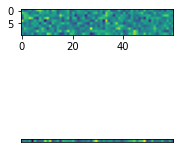

In [ ]:
fig = plt.figure()
gs = mpl.gridspec.GridSpec(nrows=2, ncols=2, height_ratios=[10, 1])
gs.
ax0 = fig.add_subplot(gs[0, 0])
ax0.imshow(data1)
ax1 = fig.add_subplot(gs[1, 0])
ax1.imshow(data2)
ax1.tick_params(which='both', bottom=False, left=False)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

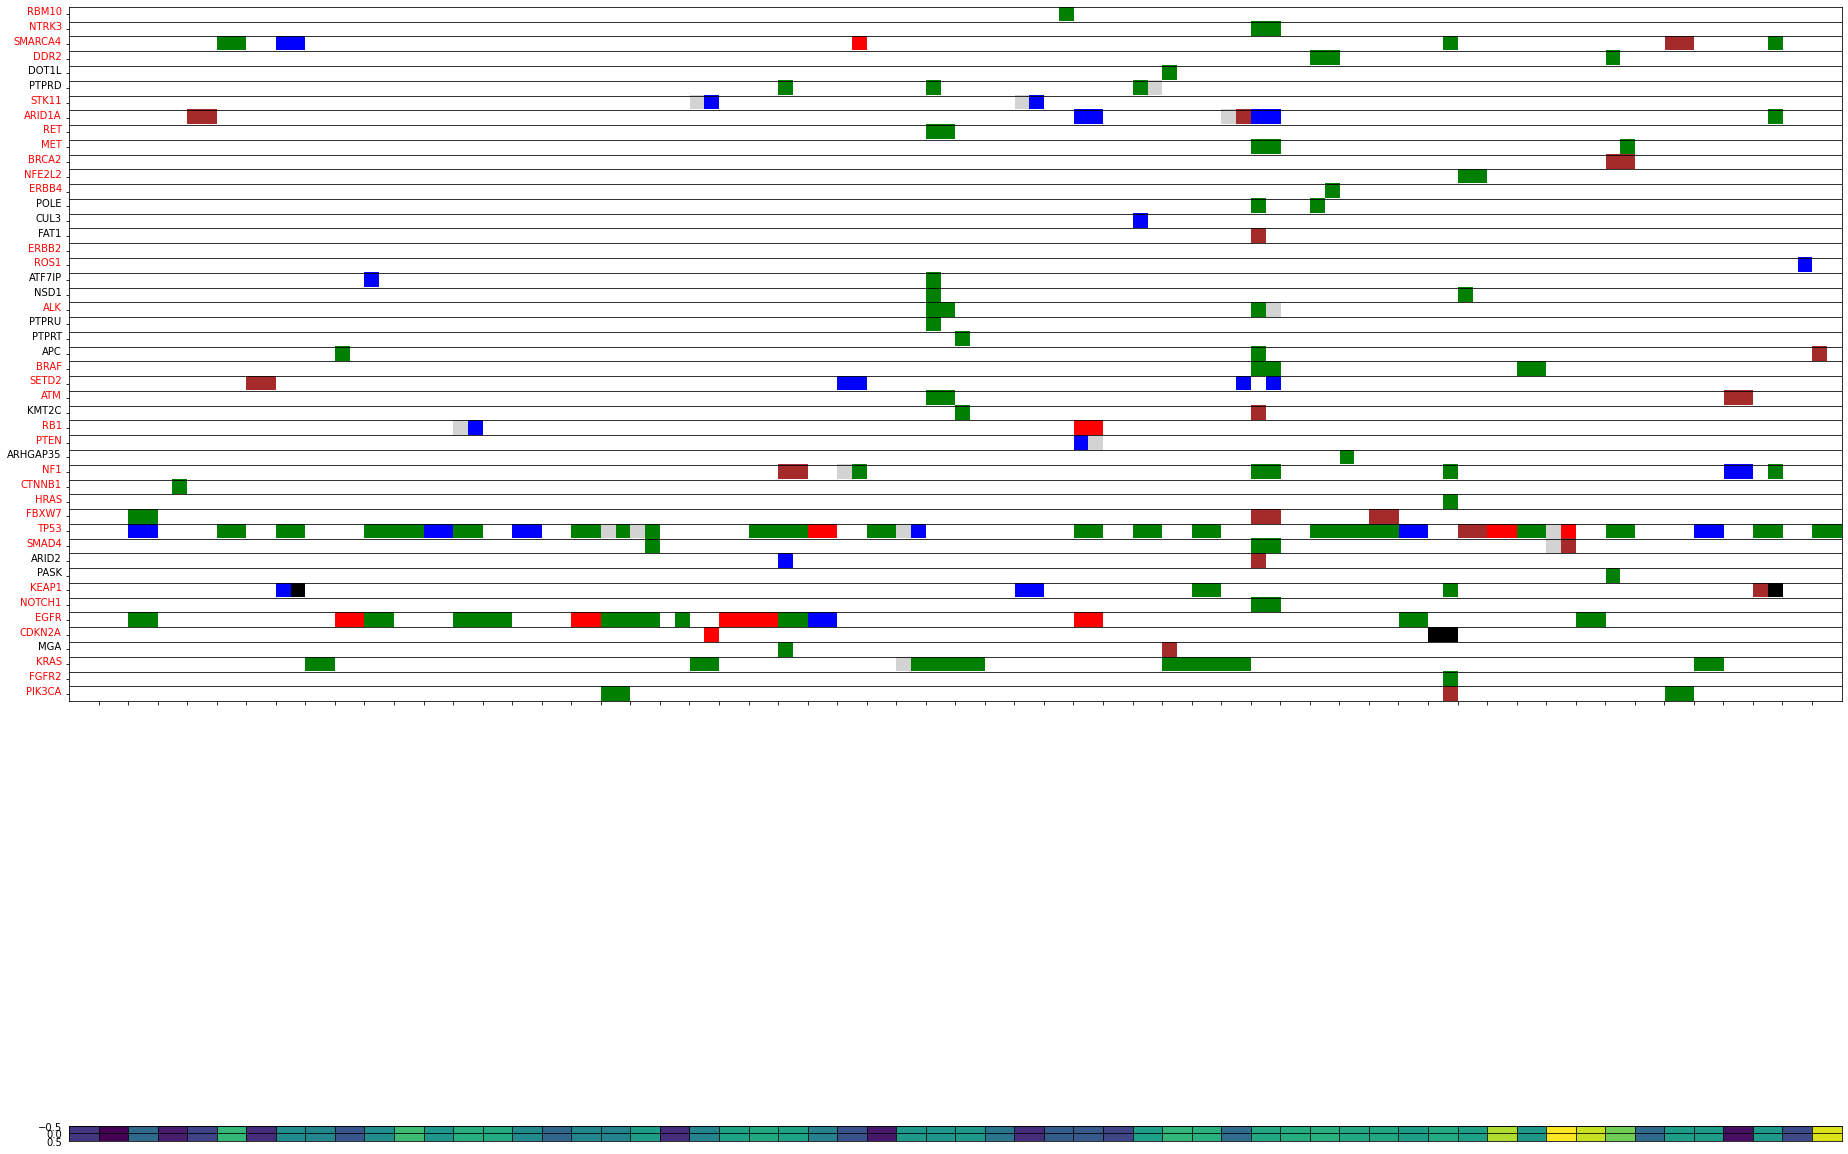

In [510]:
def main_heatmap(ax):
    cmap = mpl.colors.ListedColormap(list(heatmap_colormap.values()))
    ax.imshow(heatmap_df_num, cmap=cmap)

    ax.set_xticks(np.arange(heatmap_df_num.shape[1]))
    _ = ax.set_xticklabels(heatmap_df_num.columns, rotation=90)
    ax.set_xticks(np.arange(1.5, 1.5 + 2 * (len(SAMPLEIDS) - 1), 2), minor=True)

    ytick_positions = np.arange(heatmap_df_num.shape[0])
    ax.set_yticks(np.arange(heatmap_df_num.shape[0]))
    _ = ax.set_yticklabels([])

    gene_name_in_panel = heatmap_df_num.index.isin(panel_genes_all)
    for genename, ypos in zip(heatmap_df_num.index[gene_name_in_panel], ytick_positions[gene_name_in_panel]):
        ax.annotate(genename, xy=(-1, ypos), xycoords='data', ha='right', color='red', annotation_clip=False)
    for genename, ypos in zip(heatmap_df_num.index[~gene_name_in_panel], ytick_positions[~gene_name_in_panel]):
        ax.annotate(genename, xy=(-1, ypos), xycoords='data', ha='right', color='black', annotation_clip=False)

    ax.set_yticks(np.arange(heatmap_df_num.shape[0]) + .5, minor=True)

    ax.tick_params(which='minor', bottom=False, left=False)
    ax.tick_params(which='both', labelbottom=True, labelleft=True)
    ax.grid(which='minor', color='black', linestyle='-')

def wgs_depth(ax):
    data_dict = {'depth': list()}
    for sampleid in SAMPLEIDS_LU:
        data_dict['depth'].extend([MEAN_DEPTH_WGS_TUMOR[sampleid]] * 2)
    data_df = pd.DataFrame.from_dict(data_dict, orient='index')
    ax.imshow(data_df)
    ax.set_xticks(np.arange(1.5, 1.5 + 2 * (len(SAMPLEIDS) - 1), 2))
    ax.tick_params(which='both', bottom=False, left=False)
    ax.grid(which='major', color='black')
    
def wgs_purity(ax):
    data_dict = {'depth': list()}
    for sampleid in SAMPLEIDS_LU:
        data_dict['depth'].extend([PREVIOUS_PURITY[sampleid]] * 2)
    data_df = pd.DataFrame.from_dict(data_dict, orient='index')
    ax.imshow(data_df)
    ax.set_xticks(np.arange(1.5, 1.5 + 2 * (len(SAMPLEIDS) - 1), 2))
    ax.tick_params(which='both', bottom=False, left=False)
    ax.grid(which='major', color='black')        

    
fig = plt.figure(figsize=(40, 30))
fig.tight_layout()
gs = mpl.gridspec.GridSpec(3, 3, height_ratios=[0.9, 0.05, 0.05], width_ratios=[0.05, 0.05, 0.9])


ax_main = fig.add_subplot(gs[0, 2])
main_heatmap(ax_main)
ax_depth = fig.add_subplot(gs[1, 2], sharex=ax_main)
wgs_depth(ax_depth)


# fig, axs = plt.subplots(
#     1, 1, figsize=(40, 30), 
#     sharex=True, sharey=True, 
#     squeeze=False,
#     # width_ratios=[0.05, 0.05, 0.9], 
#     # height_ratios=[0.9, 0.05, 0.05],
# )
# main_heatmap(axs[0, 0])
# wgs_depth(axs[1, 2])
# wgs_purity(axs[2, 2])



legend_proxies = list()
for key, val in heatmap_colormap.items():
    if key == '.':
        continue
    legend_proxies.append(
        mpl.lines.Line2D(
            [], [], label=key, marker='s', markersize=10, markerfacecolor=val, markeredgewidth=0, linestyle=''
        )
    )
legend_proxies.append(
    mpl.lines.Line2D(
        [], [], label='Red gene names in panel', marker='', markersize=10, markerfacecolor=val, markeredgewidth=0, linestyle=''
    )
)
   
_ = axs[0, 0].legend(
    handles=legend_proxies,
    loc='upper left',
    bbox_to_anchor=(1.05, 1),
    fontsize=14,
)

fig.savefig('/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/21_driver_summary/heatmap_221104.pdf')

### inspect variants

In [96]:
for sampleid in SAMPLEIDS_LU:
    print(sampleid)

    print('panel snv', len(drivers_snv_panel[sampleid]))
    pprint.pprint(drivers_snv_panel[sampleid])

    print('wgs snv', len(drivers_snv_wgs[sampleid]))
    pprint.pprint(drivers_snv_wgs[sampleid])

    print('panel indel', len(drivers_indel_panel[sampleid]))
    pprint.pprint(drivers_indel_panel[sampleid])

    print('wgs indel', len(drivers_indel_wgs[sampleid]))
    pprint.pprint(drivers_indel_wgs[sampleid])
    print('\n\n')

LU-14
panel snv 0
[]
wgs snv 0
[]
panel indel 0
[]
wgs indel 0
[]



LU-6
panel snv 0
[]
wgs snv 0
[]
panel indel 0
[]
wgs indel 0
[]



LU-87
panel snv 2
[<VariantPlus object (4	153332886	.	A	C)>,
 <VariantPlus object (7	55259515	.	T	G)>]
wgs snv 2
[<VariantPlus object (4	153332886	.	A	C)>,
 <VariantPlus object (7	55259515	.	T	G)>]
panel indel 1
[<VariantPlus object (17	7573999	.	TCTCGGAA	T)>]
wgs indel 1
[<VariantPlus object (17	7573999	.	TCTCGGAA	T)>]



LU-F13
panel snv 1
[<VariantPlus object (3	41266136	.	T	C)>]
wgs snv 0
[]
panel indel 0
[]
wgs indel 0
[]



LU-F2
panel snv 1
[<VariantPlus object (1	27057874	.	C	T)>]
wgs snv 1
[<VariantPlus object (1	27057874	.	C	T)>]
panel indel 0
[]
wgs indel 0
[]



LU-F33
panel snv 2
[<VariantPlus object (17	7577098	.	T	A)>,
 <VariantPlus object (19	11101961	.	A	G)>]
wgs snv 2
[<VariantPlus object (17	7577098	.	T	A)>,
 <VariantPlus object (19	11101961	.	A	G)>]
panel indel 1
[<VariantPlus object (7	55249017	.	C	CCCA)>]
wgs indel 1
[<VariantPlu

In [529]:
sampleid = 'LU-FF1'
# sampleid = SAMPLEIDS_LU[1]
sampleid_panel = f'{sampleid}_panel'
print(sampleid)

LU-FF1


In [538]:
# vp = drivers_snv_panel[sampleid][2]
# vp = drivers_snv_wgs[sampleid][0]
vp = drivers_indel_panel[sampleid][0]
# vp = drivers_indel_wgs[sampleid][2]

In [539]:
%%capture
show_vp_igv(vp, sampleid)

In [ ]:
plt.hist([vp.get_vaf(sampleid='LU-IO16_tumor') for vp in PREVIOUS_WGS_REANNOT_VCF_SNV['LU-IO16'].vplist])

KeyError: 'LU-IO16_tumor'

(array([28.,  7.,  5.,  3.,  0.,  1.,  1.,  2.,  0.,  0.]),
 array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ]),
 <BarContainer object of 10 artists>)

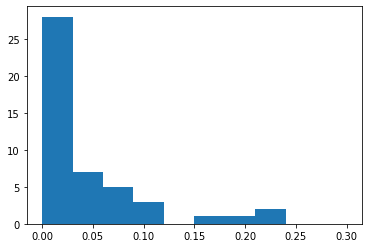

In [467]:
plt.hist([vp.get_vaf(sampleid='LU-IO16_panel') for vp in filtered_panel_vplist_snv['LU-IO16'] if not vpfilter_curated_driver_nonsyn(vp)], range=(0, 0.3))

(array([6., 1., 0., 0., 1., 0., 0., 0., 0., 0.]),
 array([0.  , 0.03, 0.06, 0.09, 0.12, 0.15, 0.18, 0.21, 0.24, 0.27, 0.3 ]),
 <BarContainer object of 10 artists>)

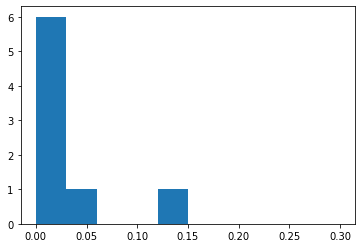

In [468]:
plt.hist([vp.get_vaf(sampleid='LU-IO16_panel') for vp in filtered_panel_vplist_snv['LU-IO16'] if vpfilter_curated_driver_nonsyn(vp)], range=(0, 0.3))

In [479]:
len(PREVIOUS_WGS_REANNOT_VCF_SNV['LU-IO16'].vplist)

21756

In [477]:
len(filtered_panel_vplist_snv['LU-IO16'])

55

In [151]:
for transcript in vp.transcript[0].canon_ovlp.values():
    if transcript['gene_name'] in curated_drivers_all:
        gene_name = transcript['gene_name']
        hgvsp = transcript['hgvsp'].split('p.')[1]
        mut_id = f'{gene_name} {hgvsp}'
        print(mut_id)
        print('polyphen', transcript['polyphen_prediction'])
        print('sift', transcript['sift_prediction'])

SETD2 Lys846Ter
polyphen None
sift None


In [220]:
# gene_names = vp.transcript[0].get_gene_names()
# print(gene_names)
print('is_oncogene', bool(gene_name in oncoKB_oncogenes))
print('is_tsg', bool(gene_name in oncoKB_tsgs))

is_oncogene True
is_tsg False


In [535]:
vp.oncokb

{'query': {'id': None,
  'referenceGenome': 'GRCh37',
  'hugoSymbol': 'KEAP1',
  'entrezGeneId': 9817,
  'alteration': 'G379S',
  'alterationType': None,
  'svType': None,
  'tumorType': None,
  'consequence': 'missense_variant',
  'proteinStart': 379,
  'proteinEnd': 379,
  'hgvs': '19:g.10602443C>T'},
 'geneExist': True,
 'variantExist': True,
 'alleleExist': True,
 'oncogenic': 'Likely Oncogenic',
 'mutationEffect': {'knownEffect': 'Likely Loss-of-function',
  'description': '',
  'citations': {'pmids': ['18692501'], 'abstracts': []}},
 'highestSensitiveLevel': None,
 'highestResistanceLevel': None,
 'highestDiagnosticImplicationLevel': None,
 'highestPrognosticImplicationLevel': None,
 'highestFdaLevel': None,
 'otherSignificantSensitiveLevels': [],
 'otherSignificantResistanceLevels': [],
 'hotspot': False,
 'geneSummary': 'KEAP1, a tumor suppressor and adaptor protein, is recurrently mutated in lung cancer.',
 'variantSummary': 'The KEAP1 G379S mutation has not been functionally 

In [186]:
set(vp.oncokb['oncogenic'] for vp in itertools.chain.from_iterable(
    itertools.chain.from_iterable(dic.values())
    for dic in (drivers_snv_panel, drivers_snv_wgs, drivers_indel_panel, drivers_indel_wgs)
))

{'Inconclusive', 'Likely Oncogenic', 'Oncogenic', 'Unknown'}

In [541]:
vp.get_vaf(sampleid + '_tumor')

0.09803921568627451

In [445]:
vp.create_cosmic()

[{'id': None,
  'occurrence': None,
  'portion_by_site': None,
  'total_occurrence': None,
  'total_portion': None,
  'occurrence_somatic': None,
  'portion_by_site_somatic': None,
  'total_occurrence_somatic': None,
  'total_portion_somatic': None}]

In [442]:
oncokb_by_hgvsg('20:g.57428617_57428617del')

{'query': {'id': None,
  'referenceGenome': 'GRCh37',
  'hugoSymbol': None,
  'entrezGeneId': None,
  'alteration': '',
  'alterationType': None,
  'svType': None,
  'tumorType': None,
  'consequence': None,
  'proteinStart': None,
  'proteinEnd': None,
  'hgvs': '20:g.57428617_57428617del'},
 'geneExist': False,
 'variantExist': None,
 'alleleExist': None,
 'oncogenic': 'Unknown',
 'mutationEffect': {'knownEffect': 'Unknown',
  'description': '',
  'citations': {'pmids': [], 'abstracts': []}},
 'highestSensitiveLevel': None,
 'highestResistanceLevel': None,
 'highestDiagnosticImplicationLevel': None,
 'highestPrognosticImplicationLevel': None,
 'otherSignificantSensitiveLevels': [],
 'otherSignificantResistanceLevels': [],
 'hotspot': None,
 'geneSummary': '',
 'variantSummary': '',
 'tumorTypeSummary': '',
 'prognosticSummary': '',
 'diagnosticSummary': '',
 'diagnosticImplications': [],
 'prognosticImplications': [],
 'treatments': [],
 'dataVersion': 'v3.15',
 'lastUpdate': '07/25/

### Create driver summary spreadsheet

In [2357]:
from handygenome.annotation import readstats as libreadstats
from handygenome import hgvs as libhgvs

def oncokb_parser(oncokb_result):
    result = dict()
    # result['gene_exists'] = oncokb_result['geneExist']
    result['known_variant'] = oncokb_result['variantExist']
    result['oncogenicity'] = oncokb_result['oncogenic']
    result['mutation_effect'] = oncokb_result['mutationEffect']['knownEffect']
    result['hotspot'] = oncokb_result['hotspot']
    
    result['sensitivity_nonlung'] = set()
    result['resistance_nonlung'] = set()
    result['sensitivity_lung'] = set()
    result['resistance_lung'] = set()

    for item in oncokb_result['treatments']:
        level = item['level']
        is_resist = ('R' in level)
        tissue = item['levelAssociatedCancerType']['tissue']
        
        if is_resist:
            if tissue.lower() == 'lung':
                result['resistance_lung'].add(level)
            else:
                result['resistance_nonlung'].add(level)
        else:
            if tissue.lower() == 'lung':
                result['sensitivity_lung'].add(level)
            else:
                result['sensitivity_nonlung'].add(level)
                
    for key in (
        'sensitivity_nonlung', 
        'resistance_nonlung', 
        'sensitivity_lung', 
        'resistance_lung',
    ):
        if len(result[key]) == 0:
            result[key] = None
        else:
            result[key] = ','.join(sorted(result[key]))
    
    return result


def make_mut_id_hgvsp(vp):
    candidates = list()
    for transcript in vp.transcript[0].canon_ovlp.values():
        if transcript['hgvsp'] is not None:
            gene_name = transcript['gene_name']
            hgvsp = transcript['hgvsp'].split('p.')[1]
            mut_id = f'{gene_name} {hgvsp}'
            candidates.append(mut_id)
    # if len(candidates) != 1:
    #     raise Exception(f'The number of hgvsp ID candidates is not 1:\n{vp}')
    return candidates[0]    


def create_line_from_vp(vp, sampleid, sampletype):
    """Args:
        sampletype: Must be "wgs" or "panel"
    """
    result = dict()
    result['CHROM'] = vp.vcfspec.chrom
    result['POS'] = vp.vcfspec.pos
    result['REF'] = vp.vcfspec.ref
    result['ALT'] = vp.vcfspec.alts[0]
    result['mutation_vcfstyle'] = vp.vcfspec.get_id()
    result['mutation_hgvsg'] = vp.vcfspec.to_hgvsg()
    result['mutation_hgvsp'] = make_mut_id_hgvsp(vp)
    
    if sampletype == 'wgs':
        result['vaf_wgs'] = vp.make_readstats(BAMS['tumor'][sampleid]).get_vaf()
        result['detected_wgs'] = True
    elif sampletype == 'panel':
        result['vaf_panel'] = vp.make_readstats(BAMS['panel'][sampleid]).get_vaf()
        result['detected_panel'] = True
    
    oncokb_result = oncokb_parser(oncokb_by_hgvsg(vp.vcfspec.to_hgvsg(), tumor_type=None))
    for key, val in oncokb_result.items():
        result[f'OncoKB_{key}'] = val
        
    gene_names = vp.transcript[0].get_gene_names()
    result['is_oncogene'] = bool(gene_names.intersection(oncogenes))
    result['is_tsg'] = bool(gene_names.intersection(tsgs))
    
    cosmic = vp.create_cosmic()[0]
    if cosmic['total_occurrence'] is None:
        cosmic_tot_occ = 0
    else:
        cosmic_tot_occ = cosmic['total_occurrence']
    
    if cosmic['occurrence'] is None:
        cosmic_bytissue = None
        cosmic_lung = 0
    else:
        cosmic_bytissue = str(cosmic['occurrence'])
        if 'lung' in cosmic['occurrence']:
            cosmic_lung = cosmic['occurrence']['lung']
        else:
            cosmic_lung = 0
            
    result['COSMIC_occurrence'] = cosmic_tot_occ
    result['COSMIC_occurrence_by_tissue'] = cosmic_bytissue
    result['COSMIC_occurrence_lung'] = cosmic_lung
        
    return result
    
    
def readstats_postprocess(readstats):
    alt_rppcount = readstats['rppcounts'][1]
    vaf = readstats.get_vaf()
    if alt_rppcount <= 1:
        detected = False
    else:
        if np.isnan(vaf) or vaf == 0:
            detected = False
        else:
            detected = True

    return detected, vaf
    
    
def create_lines(sampleid):
    drivers_snv_panel = vplist_driver_snv_panel[sampleid]
    drivers_snv_wgs = vplist_driver_snv_wgs[sampleid]
    drivers_indel_panel = vplist_driver_indel_panel[sampleid]
    drivers_indel_wgs = vplist_driver_indel_wgs[sampleid]
    
    result = dict()
    default_result_item = {
        'sampleid': sampleid,
        'detected_wgs': False,
        'detected_panel': False,
        'vaf_wgs': None,
        'vaf_panel': None,
    }
    
    vp_result_list = list()
    for vp in itertools.chain(
        drivers_snv_panel, 
        drivers_indel_panel,
    ):
        vp_result_list.append(create_line_from_vp(vp, sampleid, 'panel'))
    
    for vp in itertools.chain(
        drivers_snv_wgs, 
        drivers_indel_wgs,
    ):
        vp_result_list.append(create_line_from_vp(vp, sampleid, 'wgs'))

    for vp_result in vp_result_list:
        key = vp_result['mutation_vcfstyle']
        result.setdefault(key, default_result_item.copy())
        result[key].update(vp_result)

    # postprocess
    for key, val in result.items():
        vcfspec = libhgvs.hgvsg_to_vcfspec(val['mutation_hgvsg'], FASTA_HG19, leftmost=True)
        vcfspec_gr = vcfspec.to_gr()
        overlaps = not PANEL_REGION_GR.set_intersect(vcfspec_gr).empty
        
        if overlaps:
            if not val['detected_panel']:
                readstats = libreadstats.get_readstats(vcfspec, BAMS['panel'][sampleid], FASTA_HG19, CHROMDICT_HG19)
                detected, vaf = readstats_postprocess(readstats)
                result[key]['detected_panel'] = detected
                result[key]['vaf_panel'] = vaf
        else:
            result[key]['detected_panel'] = False
            result[key]['vaf_panel'] = np.nan
            
        if not val['detected_wgs']:
            readstats = libreadstats.get_readstats(vcfspec, BAMS['tumor'][sampleid], FASTA_HG19, CHROMDICT_HG19)
            detected, vaf = readstats_postprocess(readstats)
            result[key]['detected_wgs'] = detected
            result[key]['vaf_wgs'] = vaf
        
    return list(result.values())

In [2358]:
line_dict_list = list()
for sampleid in SAMPLEIDS_LU:
    print(sampleid)
    line_dict_list.extend(create_lines(sampleid))

LU-14


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-6
LU-87


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-F13


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-F2


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-F33


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-F37


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF1


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF104


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF115
LU-FF13


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF18


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF20


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF21


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF23


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF24


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF27
LU-FF3


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF31


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF34


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarnin

LU-FF37


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF39


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarnin

LU-FF4


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF43


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF53


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF56


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarnin

LU-FF57


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF58


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF6


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarnin

LU-FF62
LU-FF67


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF71


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF76


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF77


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF78


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF79


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF80


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-FF85


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-IO05


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-IO06


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-IO07


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarnin

LU-IO08


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-IO09


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarnin

LU-IO12


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-IO13


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-IO15


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-IO16


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarnin

LU-IO17


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-IO18


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-IO22


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-IO23


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarnin

LU-IO24


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-IO25


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarnin

LU-SC126


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-SC134


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-SC31


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


LU-SC81


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarnin

LU-SC88


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarnin

LU-SC97


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarnin

LU-SC98


/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/users/pjh/tools/miniconda/210821/miniconda3/envs/genome_v5/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [2359]:
df_nonsv = pd.DataFrame.from_dict({idx: line for idx, line in enumerate(line_dict_list)}, orient='index')

In [2360]:
df_sv_raw_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/22_panel_SV_curated/panelonly_delly_results_new_v3.csv'
df_sv_raw = pd.read_csv(df_sv_raw_path)

In [2373]:
mutation_fusion = list()
for x, y in zip(df_sv_raw['RNA_gene1'], df_sv_raw['RNA_gene2']):
    if not isinstance(x, str):
        x = 'NA'
    if not isinstance(y, str):
        y = 'NA'
    mutation_fusion.append(x + '_' + y )

chrom1s = list()
pos1s = list()
chrom2s = list()
pos2s = list()
igvkeys = list()
for idx, isnalist in df_sv_raw.isna().iterrows():
    # print(idx)
    if isnalist['CHR1_edit']:
        if isnalist['CHR1']:
            chrom1 = None
        else:
            chrom1 = df_sv_raw.iloc[idx, :]['CHR1']
    else:
        chrom1 = df_sv_raw.iloc[idx, :]['CHR1_edit']
    if chrom1 is not None:
        chrom1 = str(int(chrom1))

    if isnalist['CHR2_edit']:
        if isnalist['CHR2']:
            chrom2 = None
        else:
            chrom2 = df_sv_raw.iloc[idx, :]['CHR2']
    else:
        chrom2 = df_sv_raw.iloc[idx, :]['CHR2_edit']
    if chrom2 is not None:
        chrom2 = str(int(chrom2))
        
    if chrom1 is None:
        pos1 = None
    elif isnalist['POS1_edit']:
        pos1 = int(re.sub(',', '', df_sv_raw.iloc[idx, :]['POS1'])) 
    else:
        pos1 = int(re.sub(',', '', df_sv_raw.iloc[idx, :]['POS1_edit']))
      
    if chrom2 is None:
        pos2 = None
    elif isnalist['POS2_edit']:
        pos2 = int(re.sub(',', '', df_sv_raw.iloc[idx, :]['POS2'])) 
    else:
        pos2 = int(re.sub(',', '', df_sv_raw.iloc[idx, :]['POS2_edit']))
      
    if chrom1 is None and chrom2 is None:
        raise Exception(f'chrom1 and chrom2 both None')
    if chrom1 is None:
        igvkey = f'{chrom2}:{pos2}'
    elif chrom2 is None:
        igvkey = f'{chrom1}:{pos1}'
    else:
        igvkey = f'{chrom1}:{pos1} {chrom2}:{pos2}'
        
    igvkeys.append(igvkey)
    chrom1s.append(chrom1)
    pos1s.append(pos1)
    chrom2s.append(chrom2)
    pos2s.append(pos2)
    
dv_sv_edit = pd.DataFrame.from_dict({
    'sampleid': df_sv_raw['sampleID'],
    'detected_wgs': df_sv_raw['in_tumorWGS'],
    'detected_panel': True,
    'CHROM': chrom1s,
    'POS': pos1s,
    'CHROM2': chrom2s,
    'POS2': pos2s,
    'mutation_fusion': mutation_fusion,
    'SV_gene1': df_sv_raw['RNA_gene1'],
    'SV_gene2': df_sv_raw['RNA_gene2'],
    'igvkey_SV': igvkeys,
})

In [2374]:
dv_sv_edit = dv_sv_edit.loc[dv_sv_edit['mutation_fusion'] != 'NA_NA', :]

In [2375]:
df = pd.concat([df_nonsv, dv_sv_edit])

In [2376]:
df['purity'] = [PREVIOUS_PURITY[sampleid] for sampleid in df['sampleid']] 
df['ploidy'] = [PREVIOUS_PLOIDY[sampleid] for sampleid in df['sampleid']]
df['mean_depth_wgs_normal'] = [MEAN_DEPTH_WGS_NORMAL[sampleid] for sampleid in df['sampleid']]
df['mean_depth_wgs_tumor'] = [MEAN_DEPTH_WGS_TUMOR[sampleid] for sampleid in df['sampleid']]
df['mean_depth_panel'] = [MEAN_DEPTH_PANEL[sampleid] for sampleid in df['sampleid']]

In [2377]:
df = df.sort_values(['sampleid', 'CHROM', 'POS', 'CHROM2', 'POS2'])

In [2384]:
df

,sampleid,detected_wgs,detected_panel,vaf_wgs,vaf_panel,CHROM,POS,REF,ALT,mutation_vcfstyle,...,POS2,mutation_fusion,SV_gene1,SV_gene2,igvkey_SV,purity,ploidy,mean_depth_wgs_normal,mean_depth_wgs_tumor,mean_depth_panel
0,LU-14,True,True,NaN,NaN,2,29446603,NaN,NaN,NaN,...,42522746.0,ALK_EML4,ALK,EML4,2:29446603 2:42522746,0.31,2.6,37.3767,33.8314,925.555
1,LU-14,True,True,NaN,NaN,2,29446605,NaN,NaN,NaN,...,42522751.0,ALK_EML4,ALK,EML4,2:29446605 2:42522751,0.31,2.6,37.3767,33.8314,925.555
0,LU-14,False,True,0.000000,0.031716,4,55141027,G,A,4_55141027_G_A,...,NaN,NaN,NaN,NaN,NaN,0.31,2.6,37.3767,33.8314,925.555
1,LU-6,True,False,0.090909,NaN,11,2154344,C,T,11_2154344_C_T,...,NaN,NaN,NaN,NaN,NaN,0.16,2.3,34.0972,28.6972,828.655
2,LU-6,True,False,0.062500,NaN,16,89874756,G,A,16_89874756_G_A,...,NaN,NaN,NaN,NaN,NaN,0.16,2.3,34.0972,28.6972,828.655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,LU-SC98,True,False,0.106667,NaN,16,3633110,A,C,16_3633110_A_C,...,NaN,NaN,NaN,NaN,NaN,0.51,1.9,50.1143,59.4945,880.314
496,LU-SC98,True,True,0.220339,0.170040,17,7577139,G,A,17_7577139_G_A,...,NaN,NaN,NaN,NaN,NaN,0.51,1.9,50.1143,59.4945,880.314
500,LU-SC98,True,False,0.043478,NaN,18,56338877,T,G,18_56338877_T_G,...,NaN,NaN,NaN,NaN,NaN,0.51,1.9,50.1143,59.4945,880.314
497,LU-SC98,True,False,0.390244,NaN,5,112179006,C,A,5_112179006_C_A,...,NaN,NaN,NaN,NaN,NaN,0.51,1.9,50.1143,59.4945,880.314


In [2385]:
result_file_path = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/21_driver_summary/driver_summary_220829.tsv.gz'
df.to_csv(result_file_path, sep='\t', na_rep='NA', index=False)

In [2390]:
# idx = -1
idx = 378

In [2630]:
idx += 1
print(idx)

438


In [2631]:
from handygenome import hgvs as libhgvs

row = df.iloc[idx, :]
row_isna = row.isna()

if row_isna['mutation_hgvsg']:
    if row_isna['igvkey_SV']:
        raise Exception(f'hgvsg and igvkey_sv both None')
    gotokey = row['igvkey_SV']
else:
    gotokey = libhgvs.hgvsg_to_vcfspec(row['mutation_hgvsg'], FASTA_HG19, leftmost=True)
    
sampleid = row['sampleid']

In [2632]:
print(row)

sampleid                                                                 LU-IO16
detected_wgs                                                                True
detected_panel                                                             False
vaf_wgs                                                                 0.240741
vaf_panel                                                                    NaN
CHROM                                                                         22
POS                                                                     24176339
REF                                                                            G
ALT                                                                            A
mutation_vcfstyle                                                22_24176339_G_A
mutation_hgvsg                                                  22:g.24176339G>A
mutation_hgvsp                                                 SMARCB1 Arg377His
OncoKB_known_variant        

In [2633]:
%%capture
load_bams(sampleid)
igv.goto([gotokey], width=80)
igv.cmd('viewaspairs')

if row_isna['igvkey_SV']:
    igv.cmd('group NONE')
    igv.cmd('sort base')
else:
    igv.cmd('group PAIR_ORIENTATION')

In [1190]:
false_rows = [
    62, 63, 78, 81, 113, 165, 166, 185, 218, 219(germline), 232(germline), 303(germline), 
    304, 305(germline), 364(germline), 366, 368(germline), 369, 
]
likely_rna_contam = [
    94, 95, 96, 97, 98, 99, 100, 116, 223, 
]

68: ERBB4-CCDC3
156: detected_panel True
222: detected_wgs True
285: detected_panel True
299: detected_panel False

SyntaxError: illegal target for annotation (2921620185.py, line 7)

### plotting

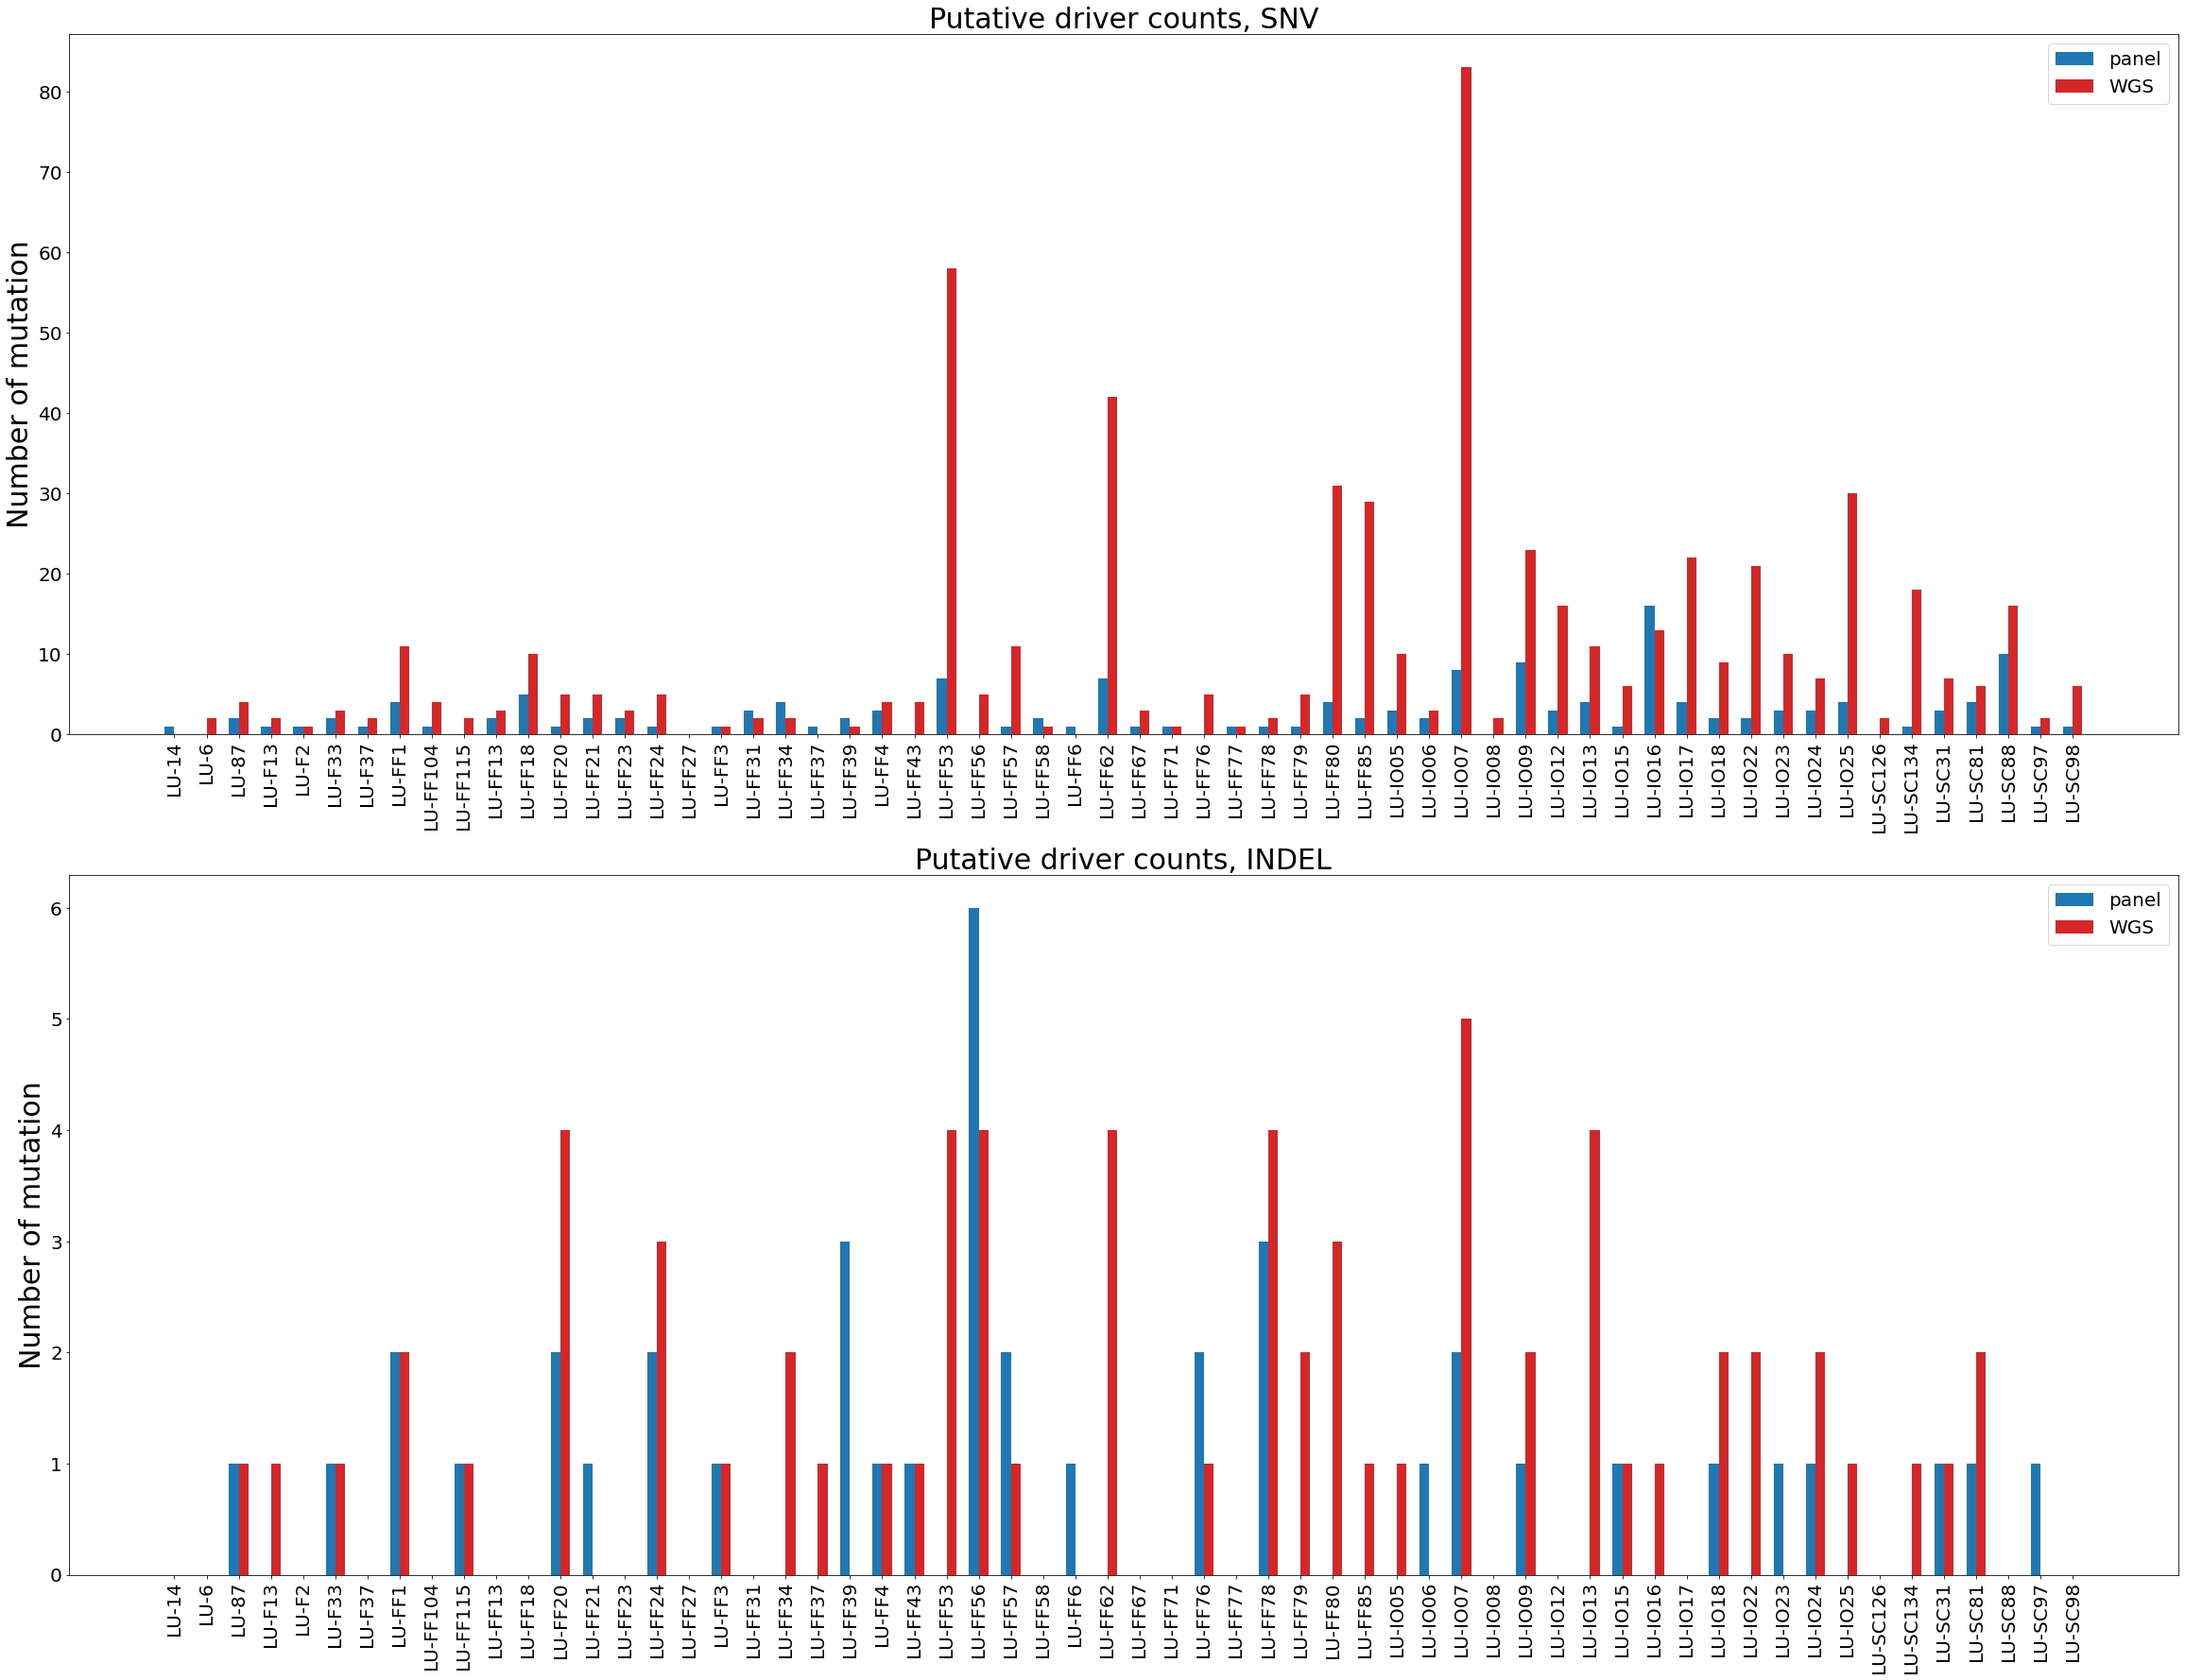

In [375]:
bar_width = 0.3

n_drivers_snv_panel = [len(vplist_driver_snv_panel[sampleid]) for sampleid in SAMPLEIDS_LU]
n_drivers_snv_wgs = [len(vplist_driver_snv_wgs[sampleid]) for sampleid in SAMPLEIDS_LU]
n_drivers_indel_panel = [len(vplist_driver_indel_panel[sampleid]) for sampleid in SAMPLEIDS_LU]
n_drivers_indel_wgs = [len(vplist_driver_indel_wgs[sampleid]) for sampleid in SAMPLEIDS_LU]

fig, axs = plt.subplots(2, 1, figsize=(40, 30))
x = np.arange(0, 60)

axs[0].bar(x - 0.5 * bar_width, n_drivers_snv_panel, width=bar_width, color='tab:blue', label='panel')
axs[0].bar(x + 0.5 * bar_width, n_drivers_snv_wgs, width=bar_width, color='tab:red', label='WGS')
axs[0].set(xticks=x, xticklabels=SAMPLEIDS_LU)
axs[0].tick_params(axis='x', direction='out', labelrotation=90, labelsize=20)
axs[0].tick_params(axis='y', labelsize=20)
# axs[0].set_xlabel('sample ID', fontsize=30)
axs[0].set_ylabel('Number of mutation', fontsize=30)
axs[0].set_title(f'Putative driver counts, SNV', fontsize=30)
axs[0].legend(fontsize=20)

axs[1].bar(x - 0.5 * bar_width, n_drivers_indel_panel, width=bar_width, color='tab:blue', label='panel')
axs[1].bar(x + 0.5 * bar_width, n_drivers_indel_wgs, width=bar_width, color='tab:red', label='WGS')
axs[1].set(xticks=x, xticklabels=SAMPLEIDS_LU)
axs[1].tick_params(axis='x', direction='out', labelrotation=90, labelsize=20)
axs[1].tick_params(axis='y', labelsize=20)
# axs[1].set_xlabel('sample ID', fontsize=30)
axs[1].set_ylabel('Number of mutation', fontsize=30)
axs[1].set_title(f'Putative driver counts, INDEL', fontsize=30)
axs[1].legend(fontsize=20)

plt.show()

In [243]:
idx = 2
sampleid = SAMPLEIDS_LU[idx]
sampleid_panel = SAMPLEIDS_LU_PANEL[idx]

# sampleid = 'LU-6'
# sampleid_panel = f'{sampleid}_panel'

print(sampleid)

def vpfilter(vp):
    return allfilter(vp, sampleid_panel)
vcfp_snv.filter_vplist(vpfilter)
vcfp_snv_wgs = PREVIOUS_WGS_REANNOT_VCF_SNV[sampleid]


LU-87


In [244]:
vp_curated_panel = [vp for vp in vcfp_snv.vplist_filtered if vpfilter_cancergene_nonsyn(vp)]
vp_curated_wgs = [vp for vp in vcfp_snv_wgs.vplist if vpfilter_cancergene_nonsyn(vp)]

print(len(vp_curated_panel))
print(len(vp_curated_wgs))

2
3


In [245]:
vplist_panel = vcfp_snv.vplist_filtered
vplist_wgs = vcfp_snv_wgs.vplist

add_oncokb_info(vplist_panel)
add_oncokb_info(vplist_wgs)

KeyboardInterrupt: 

In [200]:
# vp = vp_curated_panel[1]
vp = vp_curated_wgs[2]
show_vp_igv(vp, sampleid)

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


In [218]:
# print(json.dumps(oncokb_by_hgvsg(), indent=4))
oncokb_by_hgvsg().keys()

dict_keys(['query', 'geneExist', 'variantExist', 'alleleExist', 'oncogenic', 'mutationEffect', 'highestSensitiveLevel', 'highestResistanceLevel', 'highestDiagnosticImplicationLevel', 'highestPrognosticImplicationLevel', 'otherSignificantSensitiveLevels', 'otherSignificantResistanceLevels', 'hotspot', 'geneSummary', 'variantSummary', 'tumorTypeSummary', 'prognosticSummary', 'diagnosticSummary', 'diagnosticImplications', 'prognosticImplications', 'treatments', 'dataVersion', 'lastUpdate', 'vus'])

In [253]:
result = oncokb_by_hgvsg_post(
    hgvsg_list=[x.vcfspec.to_hgvsg() for x in vplist_panel],
    tumor_type='NSCLC',
#     evidence_types=None
    evidence_types=[
        'ONCOGENIC',
#         'DIAGNOSTIC_IMPLICATION',
#         'PROGNOSTIC_IMPLICATION',
#         'STANDARD_THERAPEUTIC_IMPLICATIONS_FOR_DRUG_SENSITIVITY',
#         'STANDARD_THERAPEUTIC_IMPLICATIONS_FOR_DRUG_RESISTANCE',
#         'INVESTIGATIONAL_THERAPEUTIC_IMPLICATIONS_DRUG_SENSITIVITY',
#         'INVESTIGATIONAL_THERAPEUTIC_IMPLICATIONS_DRUG_RESISTANCE',
    ],
)

In [255]:
result = oncokb_by_hgvsg_post(
    hgvsg_list=[x.vcfspec.to_hgvsg() for x in vplist_panel],
    tumor_type='NSCLC',
#     evidence_types=None
    evidence_types=[
        'ONCOGENIC',
        'DIAGNOSTIC_IMPLICATION',
        'PROGNOSTIC_IMPLICATION',
        'STANDARD_THERAPEUTIC_IMPLICATIONS_FOR_DRUG_SENSITIVITY',
        'STANDARD_THERAPEUTIC_IMPLICATIONS_FOR_DRUG_RESISTANCE',
        'INVESTIGATIONAL_THERAPEUTIC_IMPLICATIONS_DRUG_SENSITIVITY',
        'INVESTIGATIONAL_THERAPEUTIC_IMPLICATIONS_DRUG_RESISTANCE',
    ],
)

# INDEL analysis

### Compare panel count to WGS subsampling count

#### indel

In [116]:
for idx in range(60):
    sampleid = SAMPLEIDS_LU[idx]
    sampleid_panel = SAMPLEIDS_LU_PANEL[idx]
    print(idx, sampleid)

    def vpfilter(vp):
    #     return functionalfilter(vp) and any(readcountfilter(vp, sampleid) for sampleid in SAMPLEIDS_LU_PANEL)
    #     return cosmicfilter(vp)
    #     return (readcountfilter(vp, sampleid) and PONfilter(vp, sampleid))
        return allfilter(vp, sampleid_panel)

    vcfp_indel.filter_vplist(vpfilter)
    print(len(vcfp_indel.vplist_filtered))

    ### Pick vp and inspect

    vcfp_indel_wgs = PREVIOUS_WGS_REANNOT_VCF_INDEL[sampleid]
    vcfp_indel_wgs.filter_isec(PANEL_REGION_GR)
    print('whole genome', vcfp_indel_wgs.length)
    print('panel region', len(vcfp_indel_wgs.vplist_filtered))
    print()

0 LU-14


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


0
whole genome 201
panel region 0

1 LU-6


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


2
whole genome 71
panel region 0

2 LU-87


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


2
whole genome 289
panel region 1

3 LU-F13


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


1
whole genome 343
panel region 0

4 LU-F2


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


0
whole genome 129
panel region 0

5 LU-F33


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


2
whole genome 935
panel region 2

6 LU-F37


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


0
whole genome 273
panel region 0

7 LU-FF1


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


3
whole genome 920
panel region 2

8 LU-FF104


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


0
whole genome 336
panel region 0

9 LU-FF115


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


1
whole genome 171
panel region 1

10 LU-FF13


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


2
whole genome 310
panel region 1

11 LU-FF18


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


3
whole genome 1467
panel region 1

12 LU-FF20


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


5
whole genome 578
panel region 2

13 LU-FF21


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


3
whole genome 494
panel region 0

14 LU-FF23


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


0
whole genome 226
panel region 0

15 LU-FF24


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


2
whole genome 630
panel region 2

16 LU-FF27


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


0
whole genome 29
panel region 0

17 LU-FF3


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


1
whole genome 199
panel region 1

18 LU-FF31


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


0
whole genome 53
panel region 0

19 LU-FF34


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


0
whole genome 105
panel region 0

20 LU-FF37


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


2
whole genome 137
panel region 0

21 LU-FF39


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


3
whole genome 58
panel region 0

22 LU-FF4


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


2
whole genome 245
panel region 1

23 LU-FF43


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


3
whole genome 313
panel region 1

24 LU-FF53


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


6
whole genome 7732
panel region 5

25 LU-FF56


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


7
whole genome 1110
panel region 4

26 LU-FF57


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


3
whole genome 335
panel region 1

27 LU-FF58


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


1
whole genome 73
panel region 0

28 LU-FF6


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


1
whole genome 40
panel region 0

29 LU-FF62


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


6
whole genome 8713
panel region 8

30 LU-FF67


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


0
whole genome 324
panel region 0

31 LU-FF71


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


0
whole genome 66
panel region 0

32 LU-FF76


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


2
whole genome 262
panel region 1

33 LU-FF77


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


0
whole genome 341
panel region 0

34 LU-FF78


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


4
whole genome 138
panel region 4

35 LU-FF79


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


1
whole genome 908
panel region 0

36 LU-FF80


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


2
whole genome 3752
panel region 0

37 LU-FF85


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


4
whole genome 2156
panel region 2

38 LU-IO05


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


1
whole genome 1203
panel region 0

39 LU-IO06


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


1
whole genome 1428
panel region 0

40 LU-IO07


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


5
whole genome 6840
panel region 7

41 LU-IO08


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


0
whole genome 239
panel region 0

42 LU-IO09


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


3
whole genome 2284
panel region 1

43 LU-IO12


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


1
whole genome 2502
panel region 0

44 LU-IO13


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


2
whole genome 2464
panel region 2

45 LU-IO15


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


2
whole genome 504
panel region 2

46 LU-IO16


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


4
whole genome 1167
panel region 2

47 LU-IO17


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


6
whole genome 3521
panel region 3

48 LU-IO18


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


1
whole genome 1001
panel region 2

49 LU-IO22


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


2
whole genome 2764
panel region 1

50 LU-IO23


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


4
whole genome 1197
panel region 1

51 LU-IO24


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


1
whole genome 434
panel region 1

52 LU-IO25


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


0
whole genome 1066
panel region 1

53 LU-SC126


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


3
whole genome 69
panel region 0

54 LU-SC134


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


0
whole genome 990
panel region 0

55 LU-SC31


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


3
whole genome 708
panel region 2

56 LU-SC81


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


3
whole genome 746
panel region 1

57 LU-SC88


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


1
whole genome 1064
panel region 0

58 LU-SC97


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


3
whole genome 87
panel region 0

59 LU-SC98


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


2
whole genome 428
panel region 0



#### snv

In [117]:
for idx in range(60):
    sampleid = SAMPLEIDS_LU[idx]
    sampleid_panel = SAMPLEIDS_LU_PANEL[idx]
    print(idx, sampleid)

    def vpfilter(vp):
    #     return functionalfilter(vp) and any(readcountfilter(vp, sampleid) for sampleid in SAMPLEIDS_LU_PANEL)
    #     return cosmicfilter(vp)
    #     return (readcountfilter(vp, sampleid) and PONfilter(vp, sampleid))
        return allfilter(vp, sampleid_panel)

    vcfp_snv.filter_vplist(vpfilter)
    print(len(vcfp_snv.vplist_filtered))

    ### Pick vp and inspect

    vcfp_snv_wgs = PREVIOUS_WGS_REANNOT_VCF_SNV[sampleid]
    vcfp_snv_wgs.filter_isec(PANEL_REGION_GR)
    print('whole genome', vcfp_snv_wgs.length)
    print('panel region', len(vcfp_snv_wgs.vplist_filtered))
    print()

0 LU-14
6
whole genome 2085
panel region 2

1 LU-6
4
whole genome 1991
panel region 1

2 LU-87
14
whole genome 3084
panel region 6

3 LU-F13
3
whole genome 3853
panel region 2

4 LU-F2
4
whole genome 1206
panel region 2

5 LU-F33
4
whole genome 5876
panel region 3

6 LU-F37
11
whole genome 2914
panel region 3

7 LU-FF1
25
whole genome 17254
panel region 9

8 LU-FF104
2
whole genome 2812
panel region 3

9 LU-FF115
2
whole genome 2375
panel region 3

10 LU-FF13
9
whole genome 4203
panel region 4

11 LU-FF18
26
whole genome 28856
panel region 19

12 LU-FF20
6
whole genome 6594
panel region 3

13 LU-FF21
6
whole genome 5144
panel region 4

14 LU-FF23
8
whole genome 4081
panel region 4

15 LU-FF24
8
whole genome 10570
panel region 4

16 LU-FF27
1
whole genome 51
panel region 0

17 LU-FF3
4
whole genome 2756
panel region 2

18 LU-FF31
5
whole genome 876
panel region 1

19 LU-FF34
7
whole genome 1226
panel region 2

20 LU-FF37
4
whole genome 1270
panel region 1

21 LU-FF39
8
whole genome 252


### Filter entire VCF

In [291]:
idx = 33
sampleid = SAMPLEIDS_LU[idx]
sampleid_panel = SAMPLEIDS_LU_PANEL[idx]

# sampleid = 'LU-FF62'
# sampleid_panel = 'LU-FF62_panel'

print(sampleid)

def vpfilter(vp):
#     return functionalfilter(vp) and any(readcountfilter(vp, sampleid) for sampleid in SAMPLEIDS_LU_PANEL)
#     return cosmicfilter(vp)
#     return (readcountfilter(vp, sampleid) and PONfilter(vp, sampleid))
    return allfilter(vp, sampleid_panel)


vcfp_indel.filter_vplist(vpfilter)
print(len(vcfp_indel.vplist_filtered))

LU-FF77


/home/users/pjh/scripts/python_genome_packages/handygenome/variantplus/vpfilter.py:350: RuntimeWarning: invalid value encountered in long_scalars
  germline_sample_ratio = n_germline_vaf / len(vafs)


0


In [31]:
igv.load([BAM_PATHS['normal'][sampleid], BAM_PATHS['tumor'][sampleid], BAM_PATHS['panel'][sampleid]])

OK
OK
OK


### Pick vp and inspect

In [292]:
vcfp_indel_wgs = PREVIOUS_WGS_REANNOT_VCF_INDEL[sampleid]

In [293]:
vcfp_indel_wgs.filter_isec(PANEL_REGION_GR)
print('whole genome', vcfp_indel_wgs.length)
print('panel region', len(vcfp_indel_wgs.vplist_filtered))

whole genome 341
panel region 0


In [294]:
vcfp_indel_wgs.vplist_filtered

[]

In [83]:
igv.goto([vcfp_indel_wgs.vplist_filtered[6].vcfspec], width=100)
igv.cmd('sort base')

OK
OK


In [280]:
idx = -1

In [286]:
idx += 1
print(idx)
vp = vcfp_indel.vplist_filtered[idx]
# vp = vplist_filtered[idx]

1


In [237]:
vp = [vp for vp in vcfp_indel.vplist if vp.vcfspec == Vcfspec('15', 88408511, 'C', ('CA',))][0]

### inspect vp

In [287]:
print(vp)

<VariantPlus object (19	10610438	.	GCGGCCGGTGCATCCTGGTA	G)>


In [288]:
show_vp_igv(vp, sampleid)
# show_vp_igv(vp, 'LU-SC31')

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


In [289]:
# fi_pon = vp.get_ponfilter(sampleids=SAMPLEIDS_LU_PANEL, **ponfilter_params)
fi_pon = vp.get_ponfilter(
    sampleids=SAMPLEIDS_LU_PANEL, 
    **{
        'min_germline_vaf': 0.2,
        'germline_sample_ratio_cutoff': 0.1,
        'lowest_subset_fraction': 0.7,
        'lowest_subset_num_cutoff': 10,
        'lowest_subset_snr_cutoff': 10,
        'nearby_ratio': 3,
        'nearby_subset_num_cutoff': 5,
        'nearby_subset_snr_cutoff': 3,
        'mode': "mean",        
    }
)
mask_pon = {sampleid: fi_pon.check(vp, sampleid, exclude_target=True) for sampleid in SAMPLEIDS_LU_PANEL}
mask_all = {sampleid: allfilter(vp, sampleid) for sampleid in SAMPLEIDS_LU_PANEL}

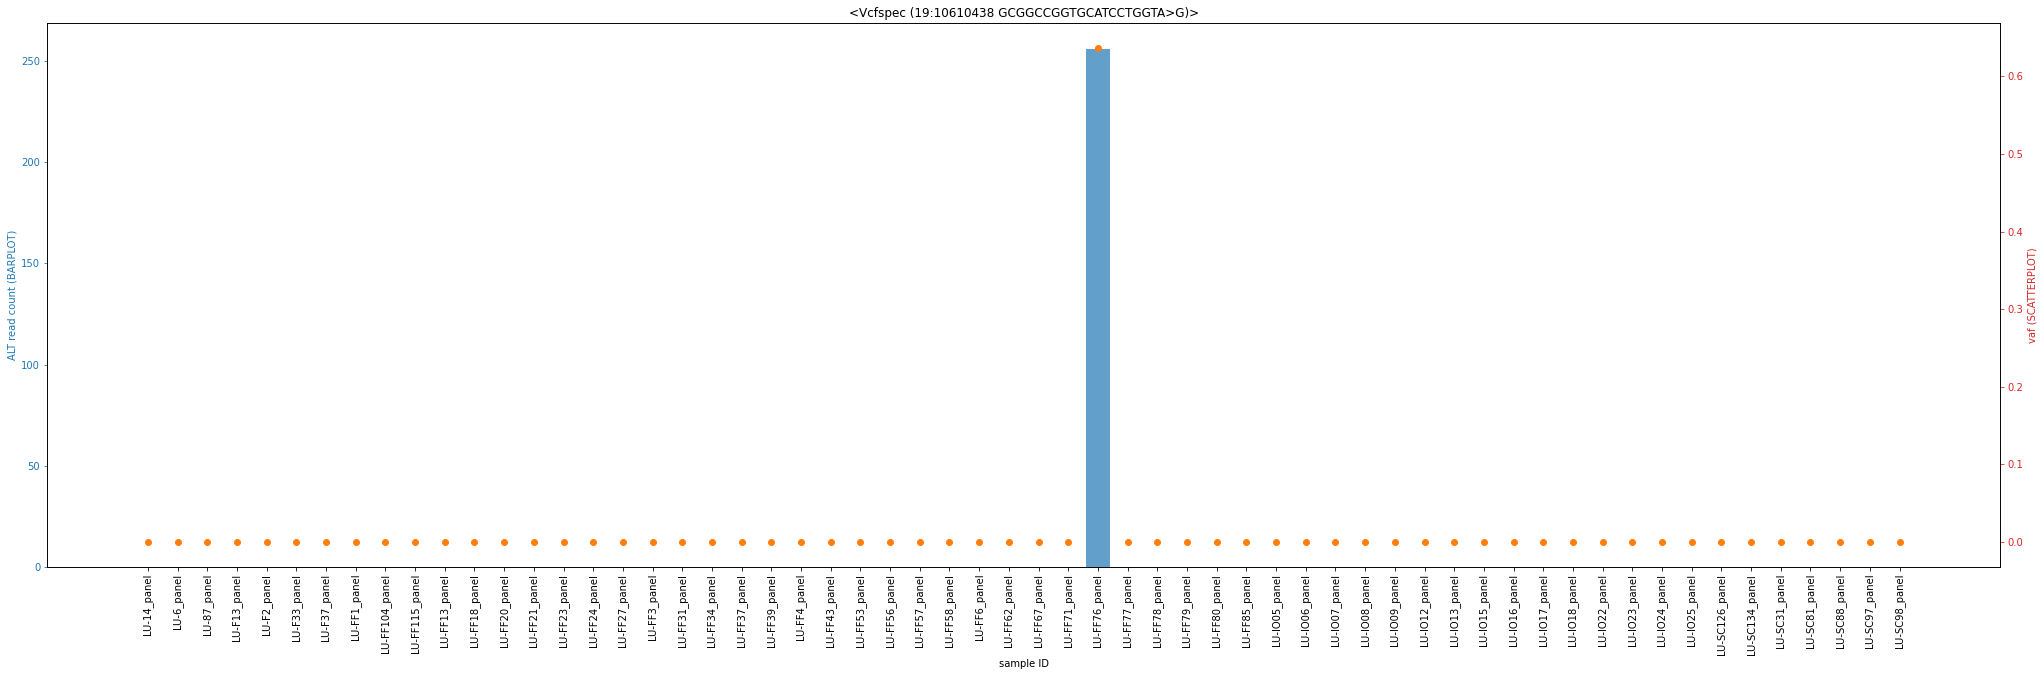

In [290]:
vp.show_readcounts(sampleids=SAMPLEIDS_LU_PANEL, figsize=(35, 10), mask=mask_pon, sort_by_value=False)
# vp.show_readcounts(sampleids=SAMPLEIDS_LU_PANEL, figsize=(35, 10), mask=mask_all, sort_by_value=False)

In [262]:
fi_pon.check(vp, sampleid='LU-IO17_panel', exclude_target=True, verbose=True)

germline_sample_ratio 0.0
lowest_summary 0.0
upper_bound 0.6666666666666666
lower_bound 0.07407407407407407
vafs_nearby_query []


True

In [269]:
vafs = fi_pon.get_vaf_dict(1)
vafs_array = np.array(list(vafs.values()))
clst = sklearn.cluster.DBSCAN(eps=0.01, min_samples=1).fit(vafs_array[:, np.newaxis])
print(clst.core_sample_indices_)
print(clst.labels_)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [1726]:
indel_counts_panel = dict()
for sampleid in SAMPLEIDS_LU:
    sampleid_panel = sampleid + '_panel'
    def vpfilter(vp):
        return allfilter(vp, sampleid_panel)
    vcfp_indel.filter_vplist(vpfilter)
    indel_counts_panel[sampleid] = len(vcfp_indel.vplist_filtered)

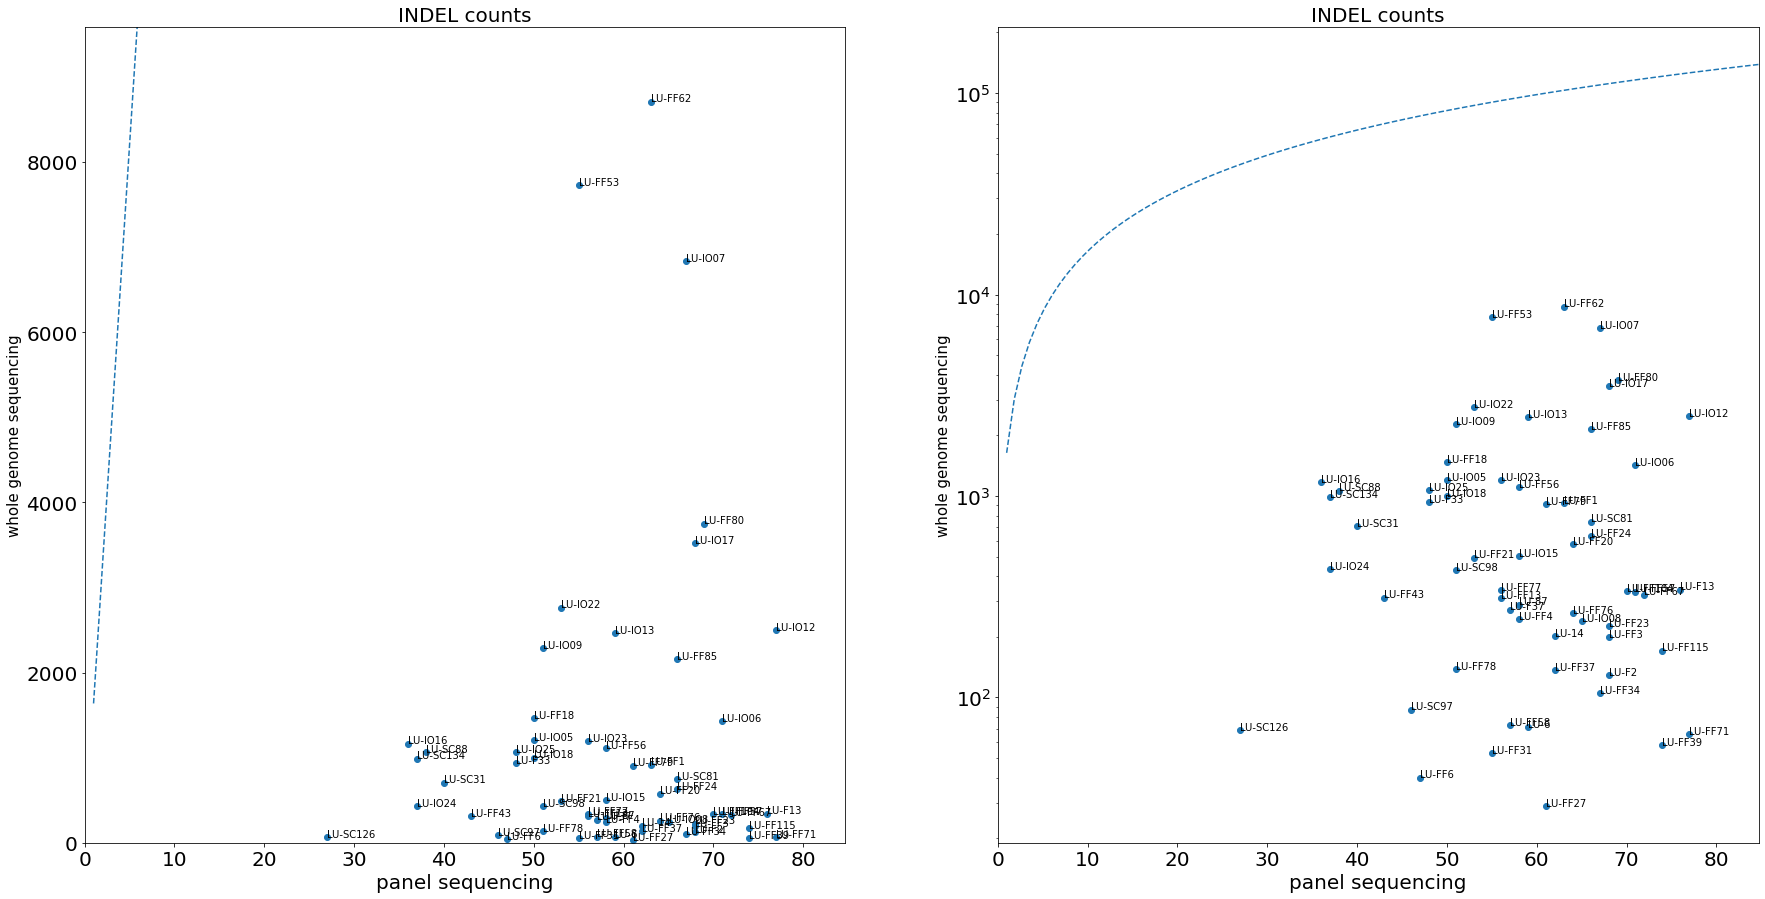

In [1727]:
%matplotlib inline

# indel_counts_panel = dict()
# for sampleid in SAMPLEIDS_LU:
#     sampleid_panel = sampleid + '_panel'
#     def vpfilter(vp):
#         return allfilter(vp, sampleid_panel)
#     vcfp_indel.filter_vplist(vpfilter)
#     indel_counts_panel[sampleid] = len(vcfp_indel.vplist_filtered)
    
indel_counts_wgs = dict()
for sampleid in SAMPLEIDS_LU:
    vcfp_indel_wgs = PREVIOUS_WGS_REANNOT_VCF_INDEL[sampleid]
    indel_counts_wgs[sampleid] = len(vcfp_indel_wgs.vplist)

x = [indel_counts_panel[sampleid] for sampleid in SAMPLEIDS_LU]
y = [indel_counts_wgs[sampleid] for sampleid in SAMPLEIDS_LU]
labels = SAMPLEIDS_LU

def plotter_indel_tmb(ax, x, y, labels, logscale=False):
    # labels
    # ax.set_title('SNV counts, without PON, without dbSNP', fontsize=20)
    ax.set_title(f'INDEL counts', fontsize=20)
    # ax.set_title('SNV counts, without PON, with dbSNP', fontsize=20)
    ax.set_xlabel('panel sequencing', fontsize=20)
    ax.set_ylabel('whole genome sequencing', fontsize=15)
    ax.tick_params('x', labelsize=20)
    ax.tick_params('y', labelsize=20)

    # xlim, ylim
    ax.set_xlim(0, max(x) * 1.1)
    # ax.set_xlim(0, 20)
    if not logscale:
        ax.set_ylim(0, max(y) * 1.1)
    # ax.set_ylim(0, 50000)

    # logscale y
    if logscale:
        ax.set_yscale('log')

    # scatterplot
    ax.scatter(x, y)

    # text annotation
    for idx, text in enumerate(labels):
        ax.annotate(text, (x[idx], y[idx]), fontsize=10)

    # abline
    ax_xlim_min, ax_xlim_max = ax.get_xlim()
    if ax_xlim_min == 0:
        ax_xlim_min = 1
    line_xvals = np.linspace(ax_xlim_min, ax_xlim_max, 100)
    line_yvals = 1638 * line_xvals
    ax.plot(line_xvals, line_yvals, '--')

    
fig, axs = plt.subplots(1, 2, figsize=(30, 15))
plotter_indel_tmb(axs[0], x, y, labels, logscale=False)
plotter_indel_tmb(axs[1], x, y, labels, logscale=True)

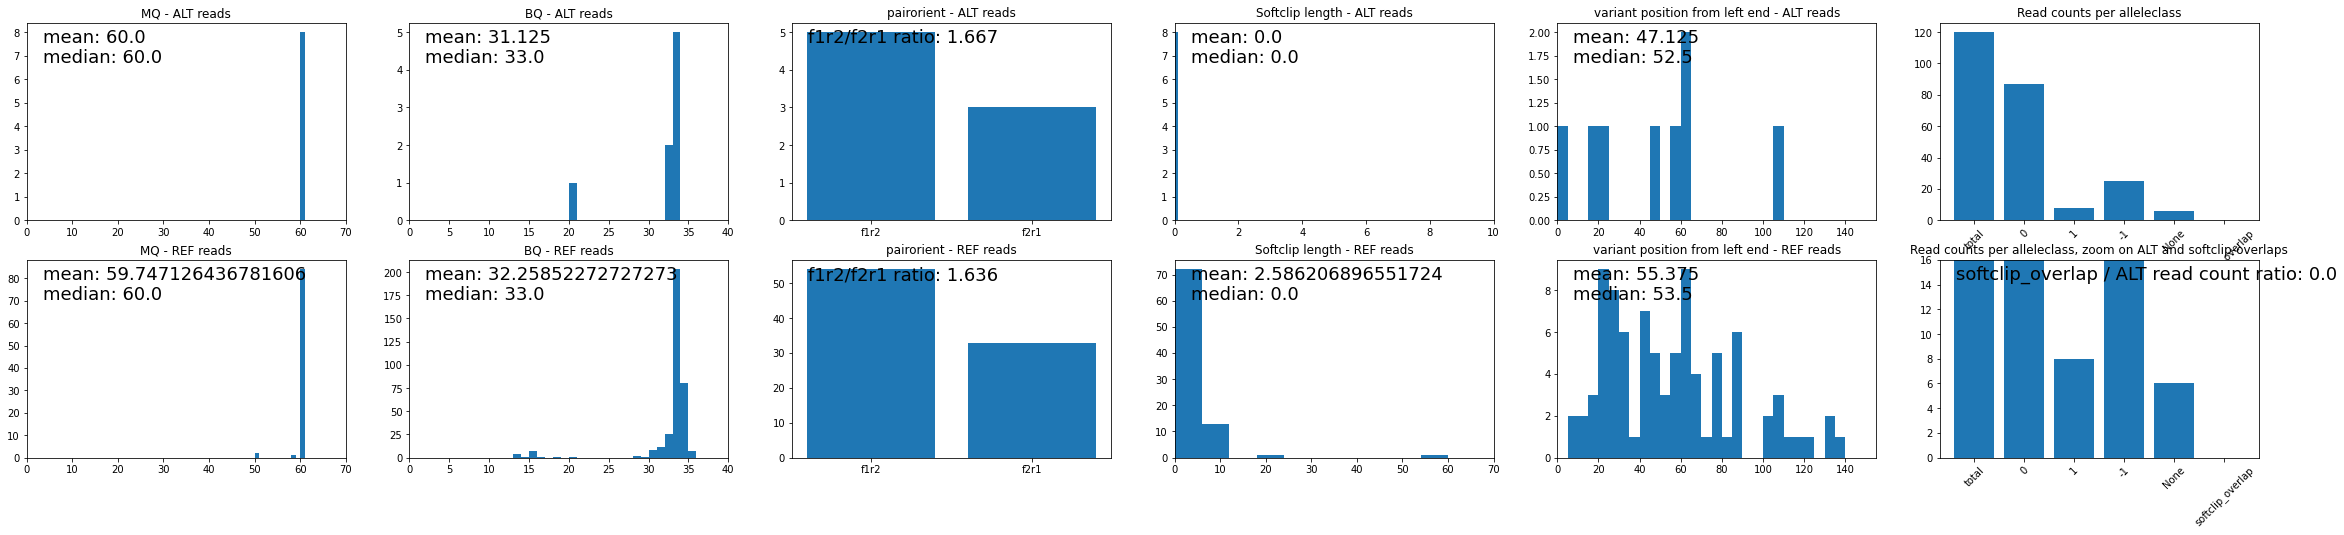

In [647]:
vp.show_readstats_data(bam=BAMS['panel'][sampleid])

# SNV analysis

### Load previous wgs vcf VAFs

In [4225]:
wgs_vafs = dict()
wgs_vcfspecs = dict()

for sampleid, vcf_path in PREVIOUS_VCF_PATHS.items():
    vaf_list = list()
    vcfspec_list = list()
    for linedict in sypark_vcf_iterator(vcf_path):
        chrom = linedict['CHROM']
        pos = int(linedict['POS'])
        ref = linedict['REF']
        alt = linedict['ALT']
        ref_read = int(linedict['ref_readN'])
        alt_read = int(linedict['var_readN'])
        
        # vaf
        total_read = ref_read + alt_read
        if total_read == 0:
            vaf = np.nan
        else:
            vaf = alt_read / total_read
        vaf_list.append(vaf)
        
        # vcfspec
        vcfspec = Vcfspec(chrom, pos, ref, (alt,))
        vcfspec_list.append(vcfspec)
        
    vaf_array = np.array(vaf_list)
    
    wgs_vafs[sampleid] = vaf_array
    wgs_vcfspecs[sampleid] = vcfspec_list

### Load previous wgs vcf Vcfspecs

In [ ]:
wgs_vcfspecs = dict()

### Previous wgs TMB data

In [29]:
wgs_tmb_df = pd.read_csv(WGS_TMB_PATH, sep='\t', index_col=0) 

wgs_snv_counts = dict()
for idx in wgs_tmb_df.index:
    wgs_snv_counts[idx] = wgs_tmb_df.loc[idx][0]

### Union-ed panel vcf path

In [1379]:
PANEL_VCF_PATH = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/220531/04_panel_union_all/panel_union.annot.readstats_wgs.vcf.gz'

### Filter by panel bait region

In [21]:
for vcfp in vcfp_dict.values():
    vcfp.filter_isec(PANEL_REGION_GR)

In [47]:
outdir = '/home/users/team_projects/Lung_Cancer_Panel_data/03_Data_from_YTKim/09_short_variants_union/220531/03_panel_filter_panelregion/'
for sampleid, vcfp in vcfp_dict.items():
    print(sampleid)
    outfile_path = os.path.join(outdir, f'{sampleid}.vcf.gz')
    vcfp.write(outfile_path, vcfp.vplist_filtered)

14
6
87
F13
F2
F33
F37
FF1
FF104
FF115
FF13
FF18
FF20
FF21
FF23
FF24
FF27
FF3
FF31
FF34
FF37
FF39
FF4
FF43
FF53
FF56
FF57
FF58
FF6
FF62
FF67
FF71
FF76
FF77
FF78
FF79
FF80
FF85
IO04
IO05
IO06
IO07
IO08
IO09
IO12
IO13
IO15
IO16
IO17
IO18
IO22
IO23
IO24
IO25
SC126
SC134
SC31
SC81
SC88
SC97
SC98


### Load VcfPlus

In [24]:
vcfp = VcfPlus(PANEL_VCF_PATH, set_annotdb=True, set_readstats=True, logging_lineno=1000)

[KST 2022-07-06 14:19:54 INFO] panel_union.annot.readstats_wgs.vcf.gz: 1000 variant records processed
[KST 2022-07-06 14:20:13 INFO] panel_union.annot.readstats_wgs.vcf.gz: 2000 variant records processed
[KST 2022-07-06 14:20:33 INFO] panel_union.annot.readstats_wgs.vcf.gz: 3000 variant records processed
[KST 2022-07-06 14:20:52 INFO] panel_union.annot.readstats_wgs.vcf.gz: 4000 variant records processed
[KST 2022-07-06 14:21:11 INFO] panel_union.annot.readstats_wgs.vcf.gz: 5000 variant records processed


### Sample swap test - normal wgs germline variants check

In [4139]:
sampleid = SAMPLEIDS_LU[61]
print(sampleid)

def check_between(val, limits):
    return (val > limits[0] and val < limits[1])

width = 0.3
limits = (0.5 - width, 0.5 + width)

vplist_normal_germlines = [vp for vp in vcfp.vplist if 
                           (vp.get_vaf(f'{sampleid}_normal') is not None and
                            check_between(vp.get_vaf(f'{sampleid}_normal'), limits))]
print(len(vplist_normal_germlines))

IndexError: list index out of range

In [4074]:
vplist_sampled = random.sample(vplist_normal_germlines, 30)
# vplist_sampled = vplist_normal_germlines

In [4075]:
idx = -1

In [4137]:
idx += 1
print(f'idx = {idx}')

idx = 30


In [4138]:
sampleid_igvshow = sampleid
# sampleid_igvshow = SAMPLEIDS_LU[59]

print(idx)
vp = vplist_sampled[idx]
show_vp_igv(vp, sampleid_igvshow)
# igv.cmd('sort start')

30


IndexError: list index out of range

### Plot signatures

In [4231]:
panel_vcfspecs = dict()
for sampleid, vplist in filtered_vplists.items():
    panel_vcfspecs[sampleid] = [vp.vcfspec for vp in vplist]

In [4251]:
from handygenome.signature.signatureresult import get_sigresult_from_vcfspecs

sampleid = 'LU-IO17'

sigresult_panel = get_sigresult_from_vcfspecs(panel_vcfspecs[sampleid], refver='GRCh37')
sigresult_wgs = get_sigresult_from_vcfspecs(wgs_vcfspecs[sampleid], refver='GRCh37')

[KST 2022-06-24 13:55:01 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2022-06-24 13:55:01 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2022-06-24 13:55:01 INFO] handygenome.signature.signatureresult: All finished.
[KST 2022-06-24 13:55:01 INFO] handygenome.signature.signatureresult: Creating mutation catalogue
[KST 2022-06-24 13:55:04 INFO] handygenome.signature.signatureresult: Running SigProfilerAssignment
[KST 2022-06-24 13:55:04 INFO] handygenome.signature.signatureresult: All finished.


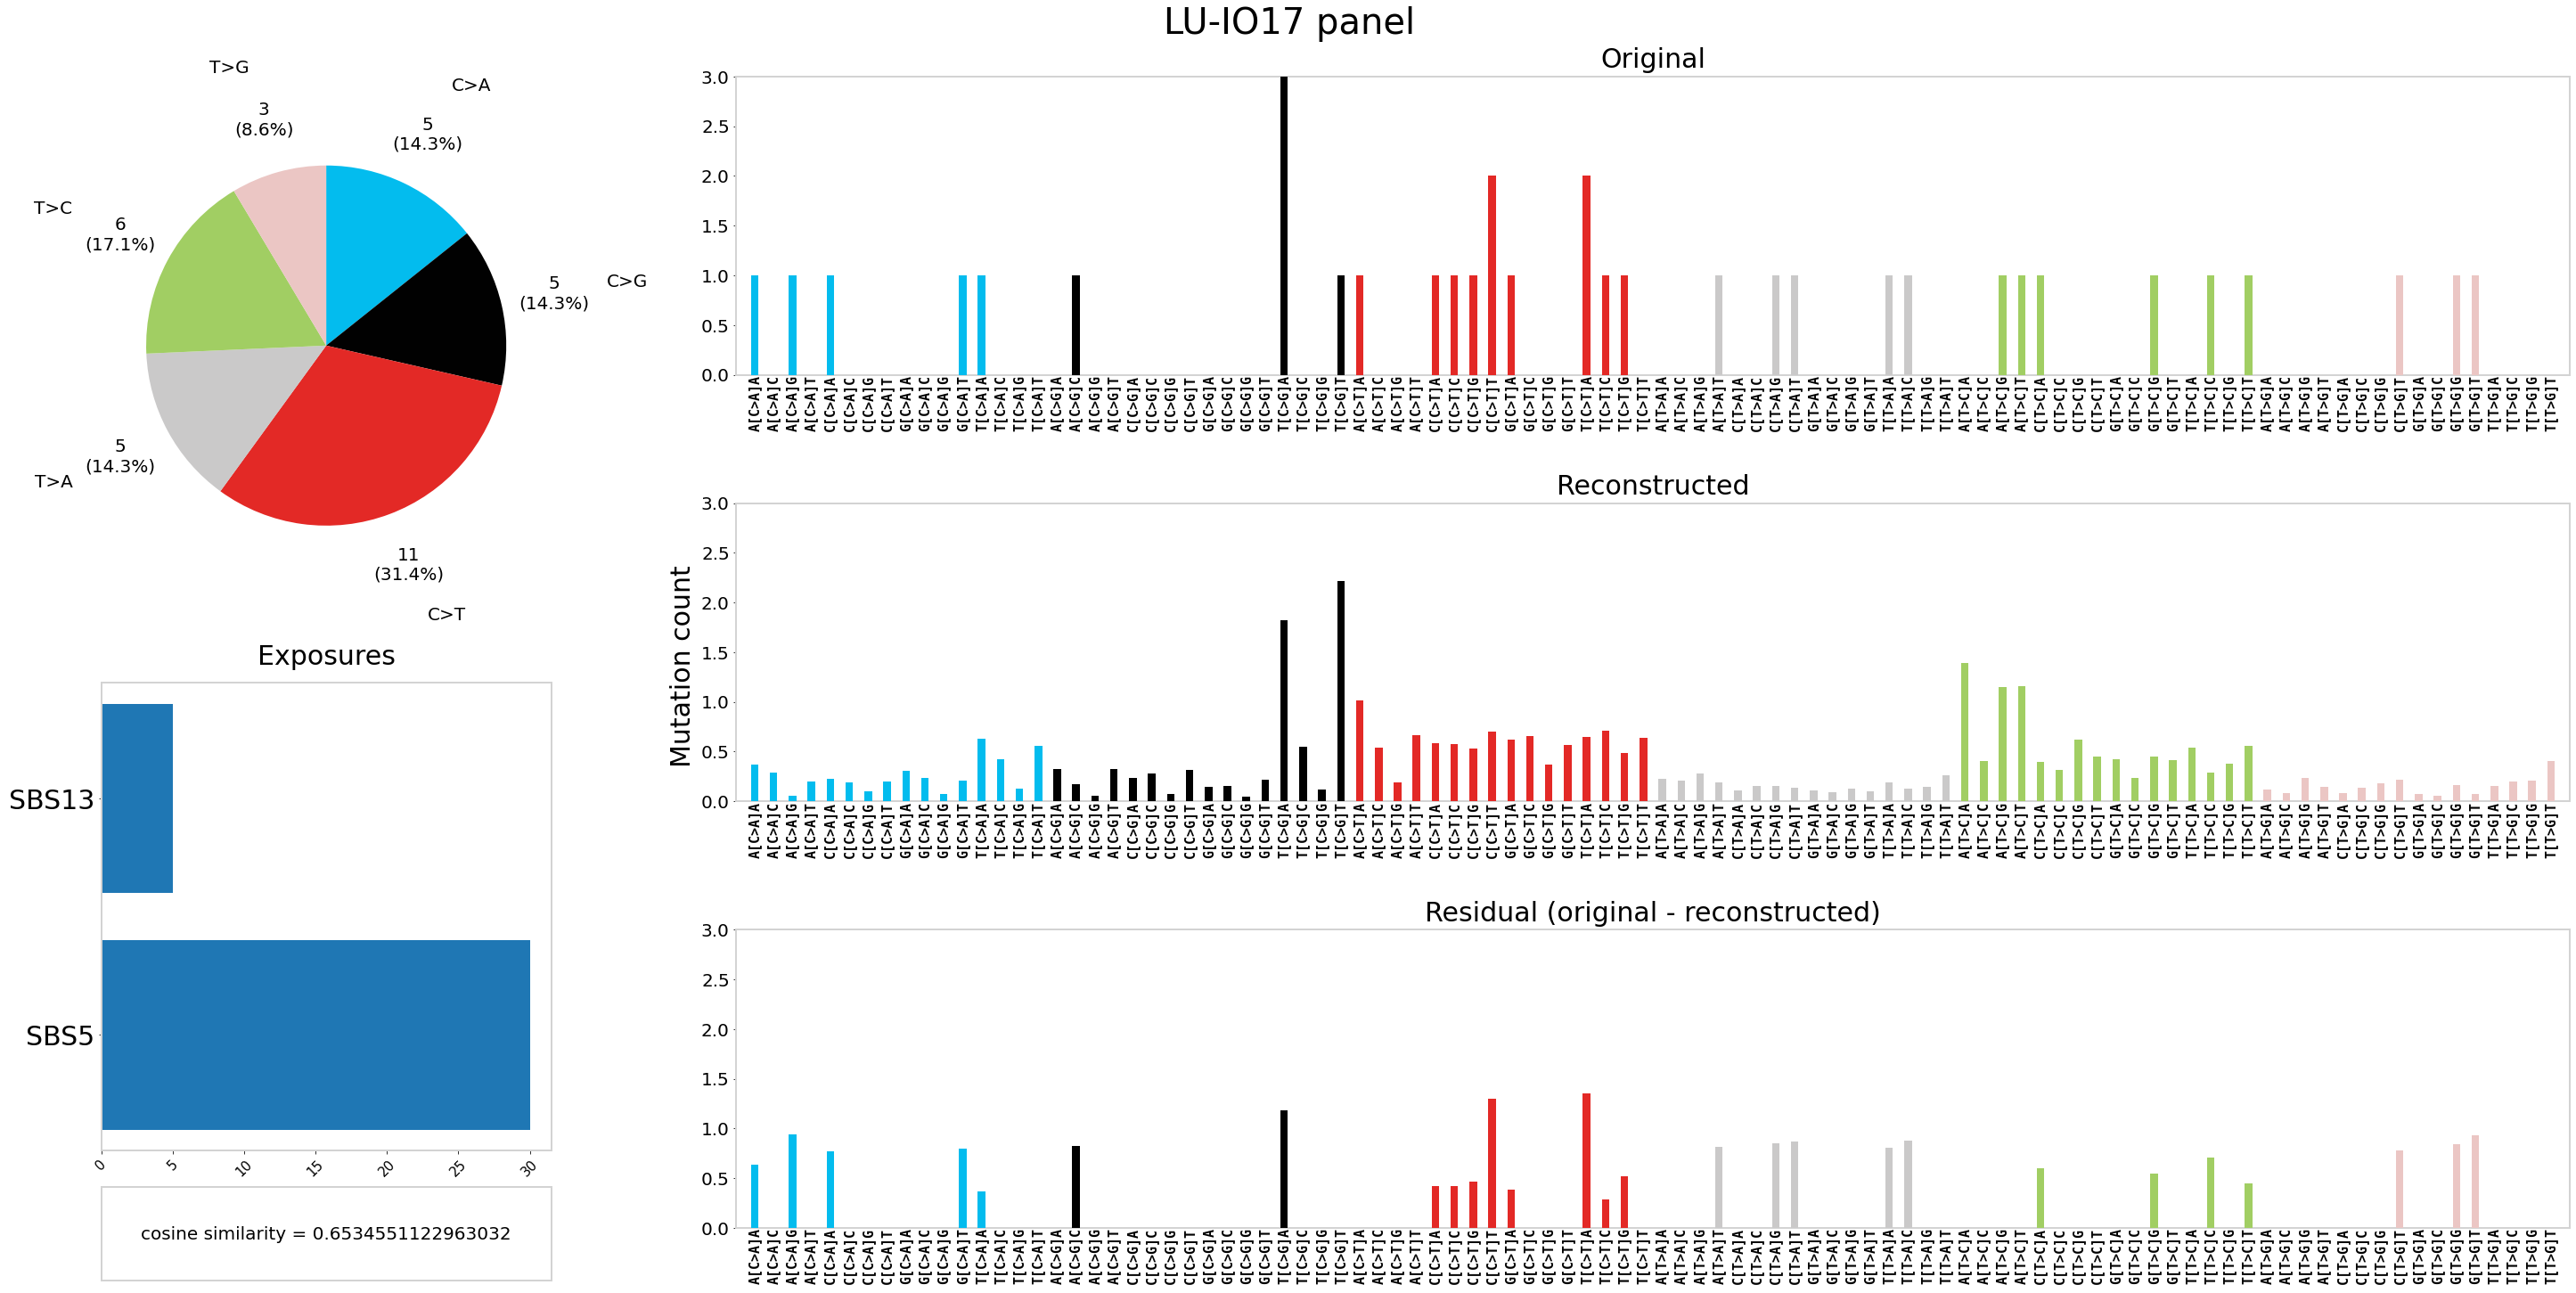

In [4252]:
sigresult_panel.plot(sampleid + ' panel')

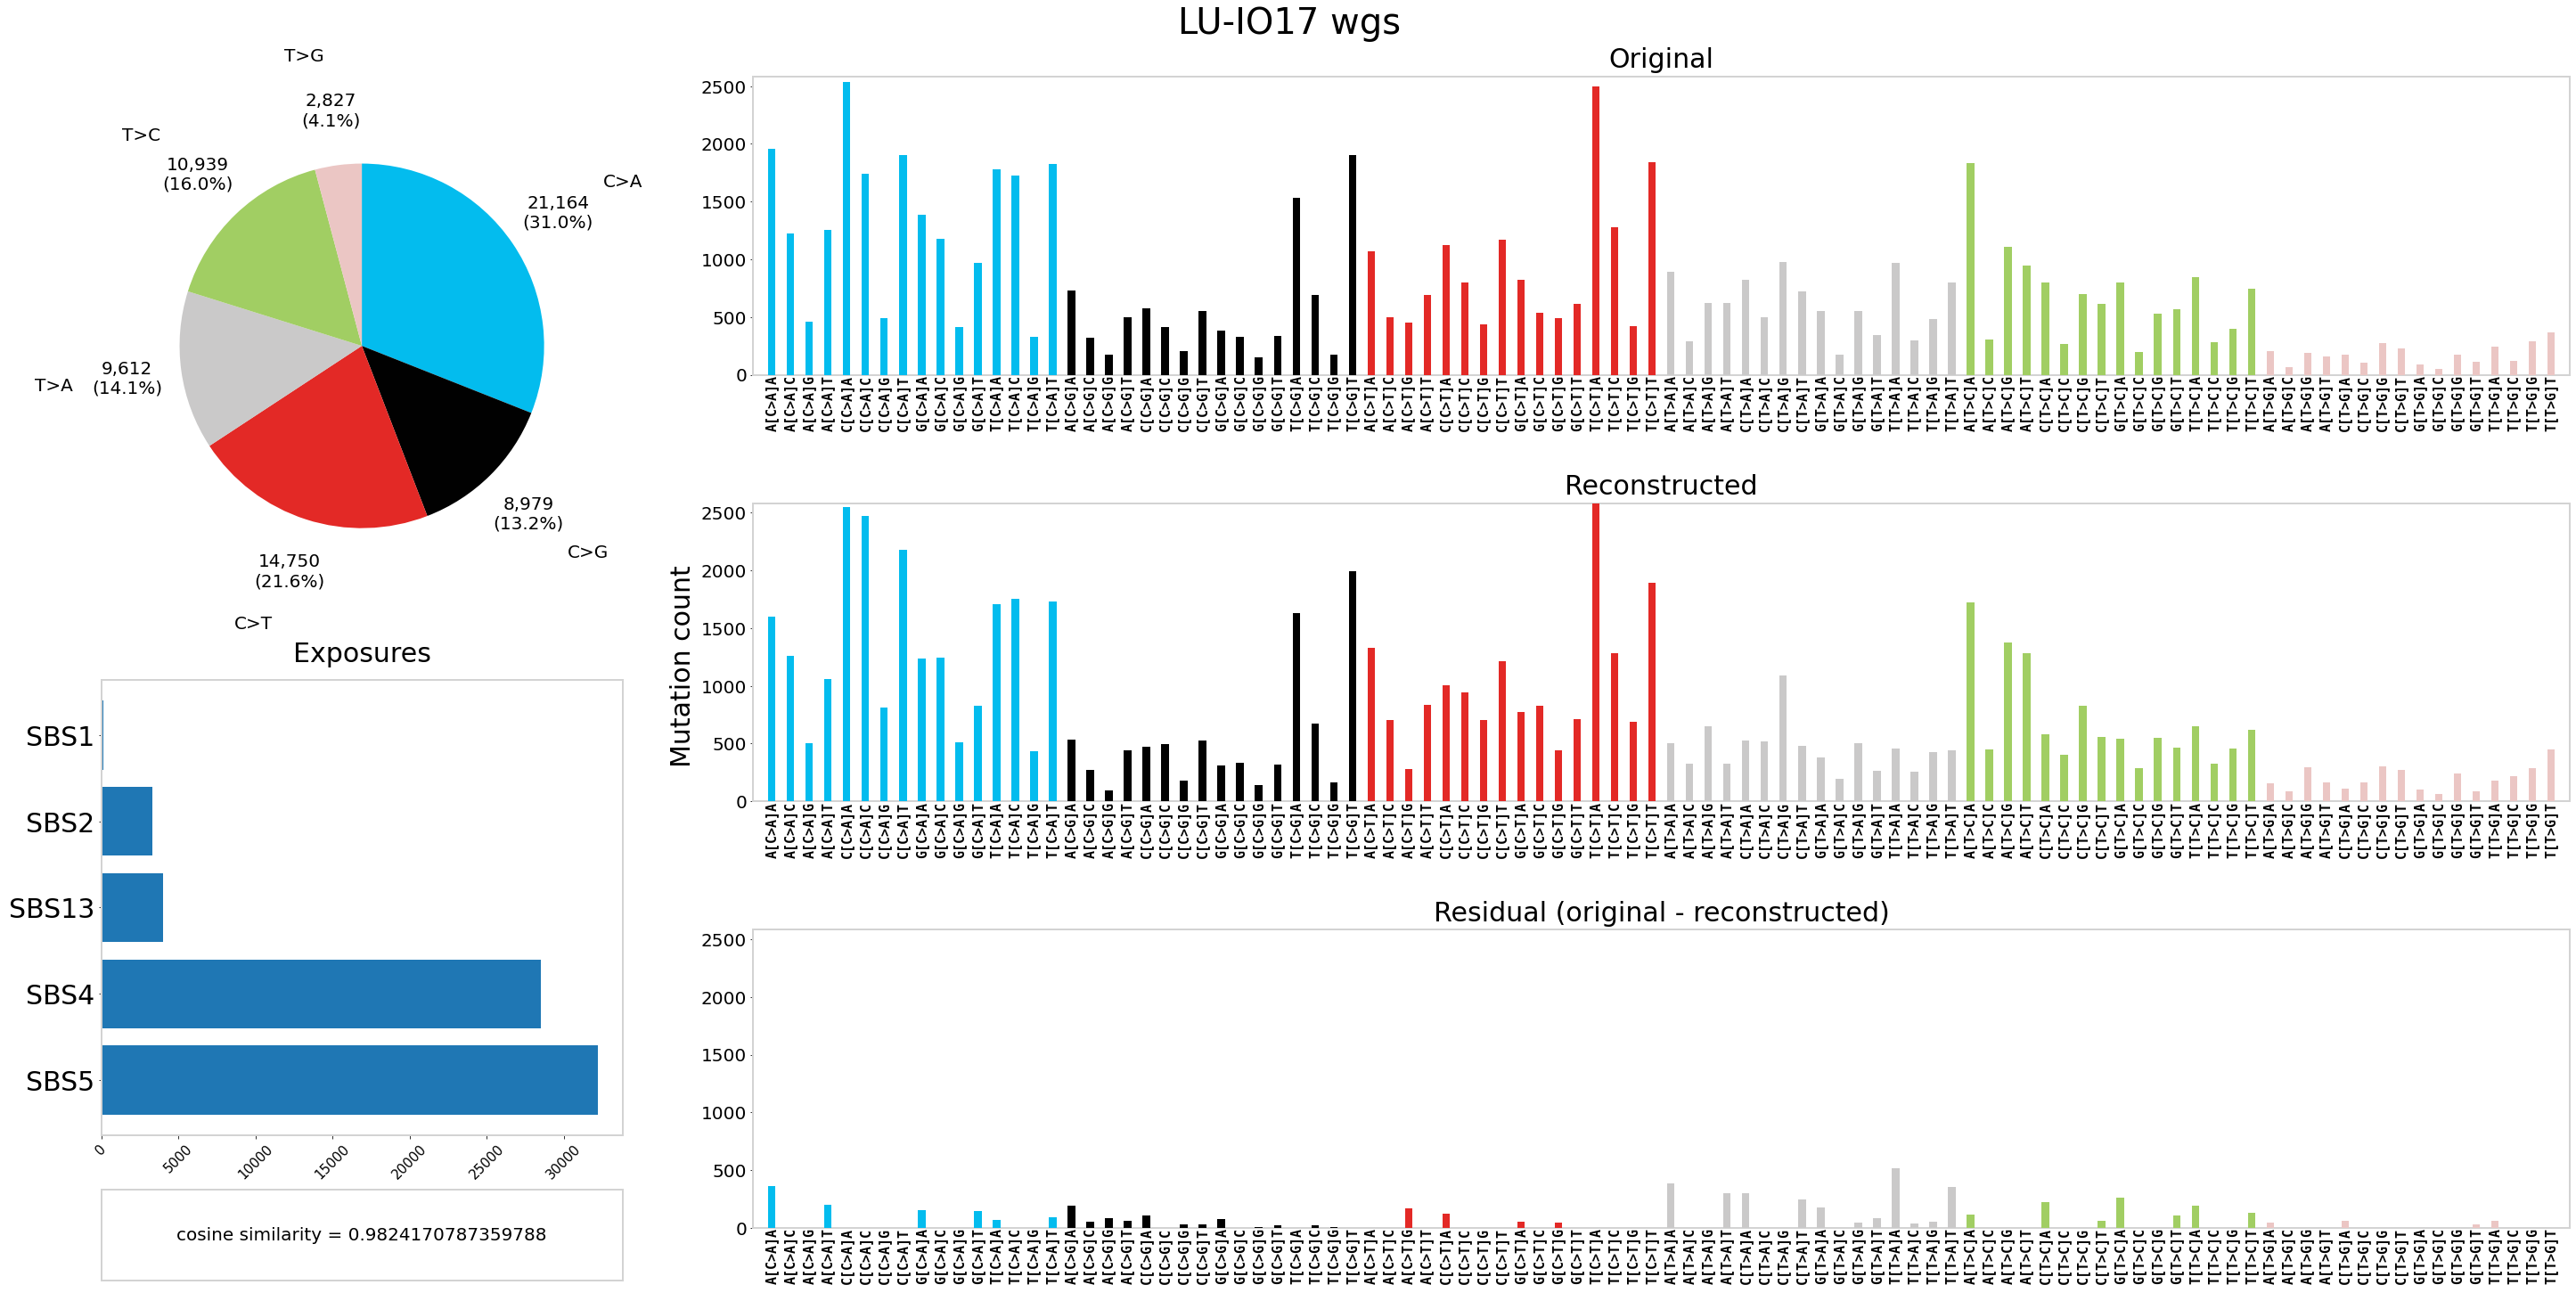

In [4253]:
sigresult_wgs.plot(sampleid + ' wgs')

<Vcfspec (1:3130443 C>T)>

### Plot snv counts

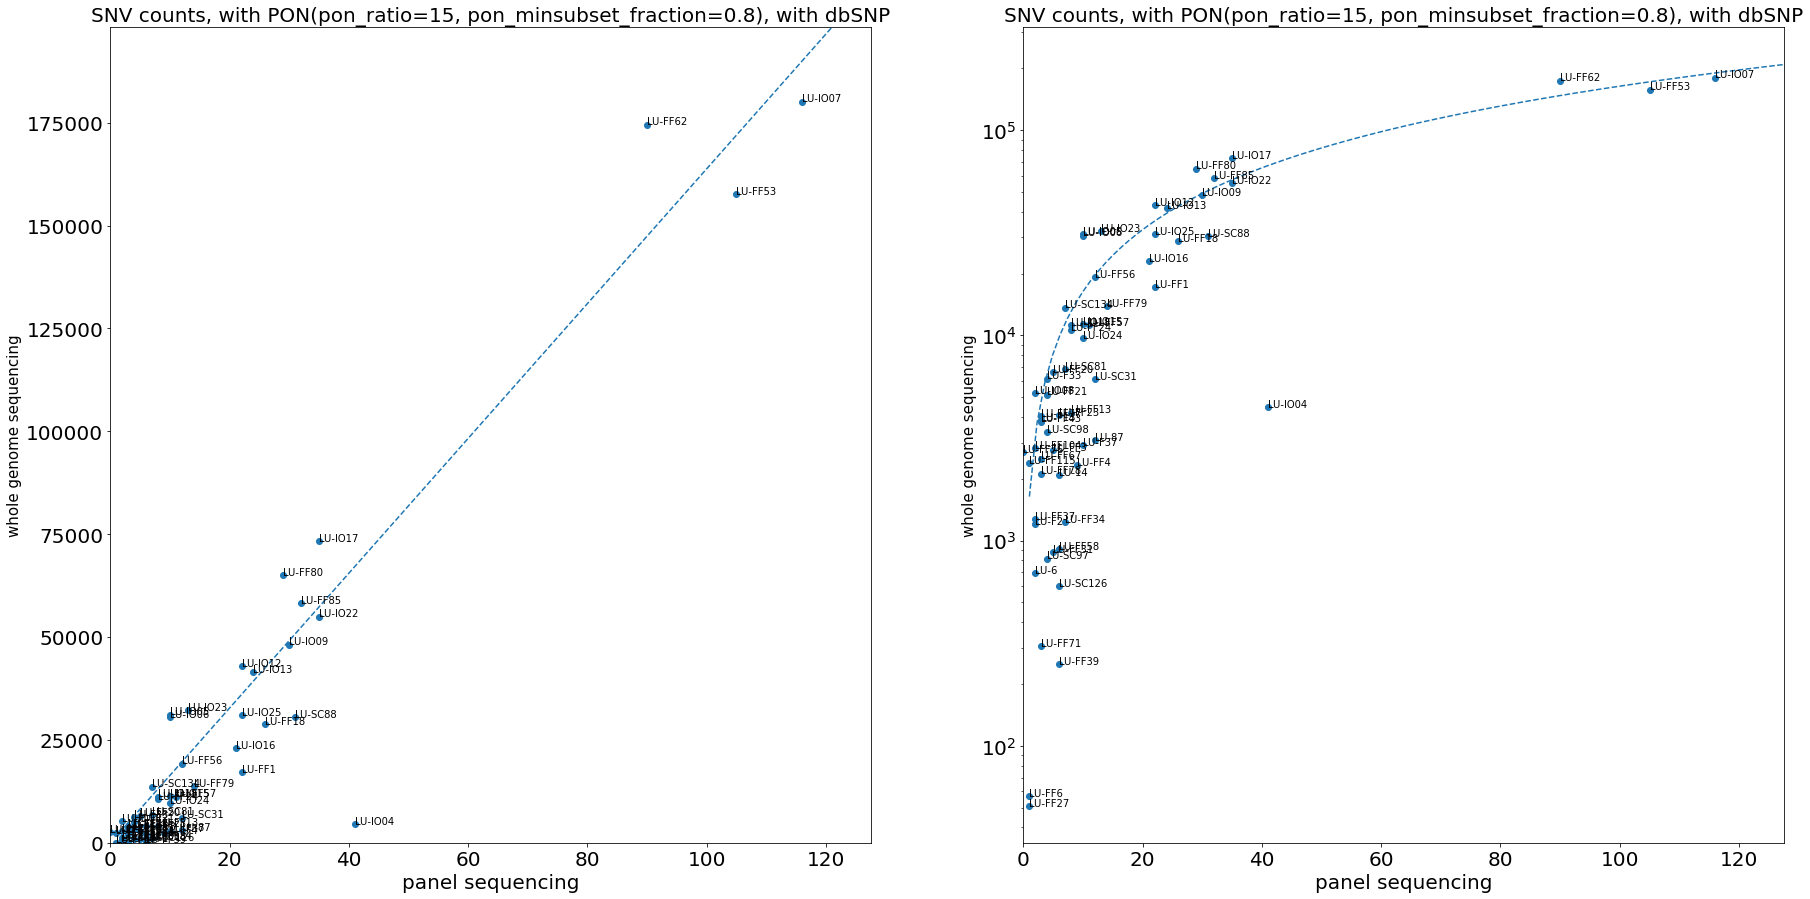

In [43]:
%matplotlib inline

snv_counts_panel = {sampleid: len(vplist) 
                    for sampleid, vplist in filtered_vplists.items()}
x = [snv_counts_panel[sampleid] for sampleid in SAMPLEIDS_LU]
y = [snv_counts_wgs[sampleid] for sampleid in SAMPLEIDS_LU]
labels = SAMPLEIDS_LU

def plotter_snv_tmb(ax, x, y, labels, pon_ratio, pon_minsubset_fraction, logscale=False):
    # labels
    # ax.set_title('SNV counts, without PON, without dbSNP', fontsize=20)
    ax.set_title(
        f'SNV counts, with PON(pon_ratio={pon_ratio}, '
        f'pon_minsubset_fraction={pon_minsubset_fraction}), with dbSNP', 
        fontsize=20)
    # ax.set_title('SNV counts, without PON, with dbSNP', fontsize=20)
    ax.set_xlabel('panel sequencing', fontsize=20)
    ax.set_ylabel('whole genome sequencing', fontsize=15)
    ax.tick_params('x', labelsize=20)
    ax.tick_params('y', labelsize=20)

    # xlim, ylim
    ax.set_xlim(0, max(x) * 1.1)
    # ax.set_xlim(0, 20)
    if not logscale:
        ax.set_ylim(0, max(y) * 1.1)
    # ax.set_ylim(0, 50000)

    # logscale y
    if logscale:
        ax.set_yscale('log')

    # scatterplot
    ax.scatter(x, y)

    # text annotation
    for idx, text in enumerate(labels):
        ax.annotate(text, (x[idx], y[idx]), fontsize=10)

    # abline
    ax_xlim_min, ax_xlim_max = ax.get_xlim()
    if ax_xlim_min == 0:
        ax_xlim_min = 1
    line_xvals = np.linspace(ax_xlim_min, ax_xlim_max, 100)
    line_yvals = 1638 * line_xvals
    ax.plot(line_xvals, line_yvals, '--')

    
fig, axs = plt.subplots(1, 2, figsize=(30, 15))
plotter_snv_tmb(axs[0], x, y, labels, pon_ratio, pon_minsubset_fraction, logscale=False)
plotter_snv_tmb(axs[1], x, y, labels, pon_ratio, pon_minsubset_fraction, logscale=True)

### Plot TMB

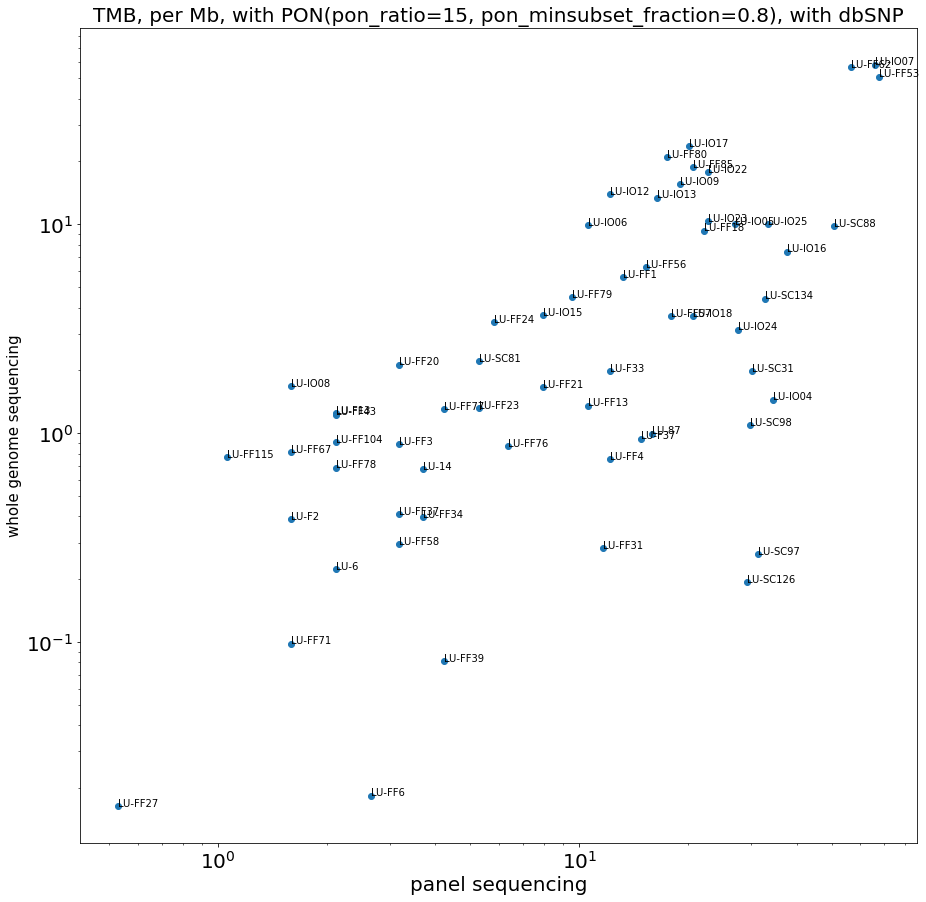

In [594]:
x = [1e6 * snv_counts_panel[sampleid] / PANEL_REGION_LENGTH for sampleid in SAMPLEIDS_LU]
y = [1e6 * snv_counts_wgs[sampleid] / WHOLE_GENOME_LENGTH for sampleid in SAMPLEIDS_LU]
labels = SAMPLEIDS_LU

fig, ax = plt.subplots(figsize=(15, 15))
logscale = False

# labels
# ax.set_title('SNV counts, without PON, without dbSNP', fontsize=20)
ax.set_title(f'TMB, per Mb, with PON(pon_ratio={pon_ratio}, pon_minsubset_fraction={pon_minsubset_fraction}), with dbSNP', fontsize=20)
# ax.set_title('SNV counts, without PON, with dbSNP', fontsize=20)
ax.set_xlabel('panel sequencing', fontsize=20)
ax.set_ylabel('whole genome sequencing', fontsize=15)
ax.tick_params('x', labelsize=20)
ax.tick_params('y', labelsize=20)

# xlim, ylim
# ax.set_xlim(0, max(x) * 1.1)
# ax.set_xlim(0, 20)
# if not logscale:
#     ax.set_ylim(0, max(y) * 1.1)
# ax.set_ylim(0, 50000)

# logscale
ax.set_xscale('log')
ax.set_yscale('log')

# scatterplot
ax.scatter(x, y)

# text annotation
for idx, text in enumerate(labels):
    ax.annotate(text, (x[idx], y[idx]), fontsize=10)

In [493]:
show_vp_igv(vp, sampleid)

OK
OK
OK
OK
OK
OK
OK
OK
OK
OK


### Load panel vcf VAFs

In [92]:
panel_vafs = dict()
for sampleid, vplist in filtered_vplists.items():
    vafarray = np.array([vp.get_vaf(sampleid) for vp in vplist])
    panel_vafs[sampleid] = vafarray

### Draw VAF scatterplot

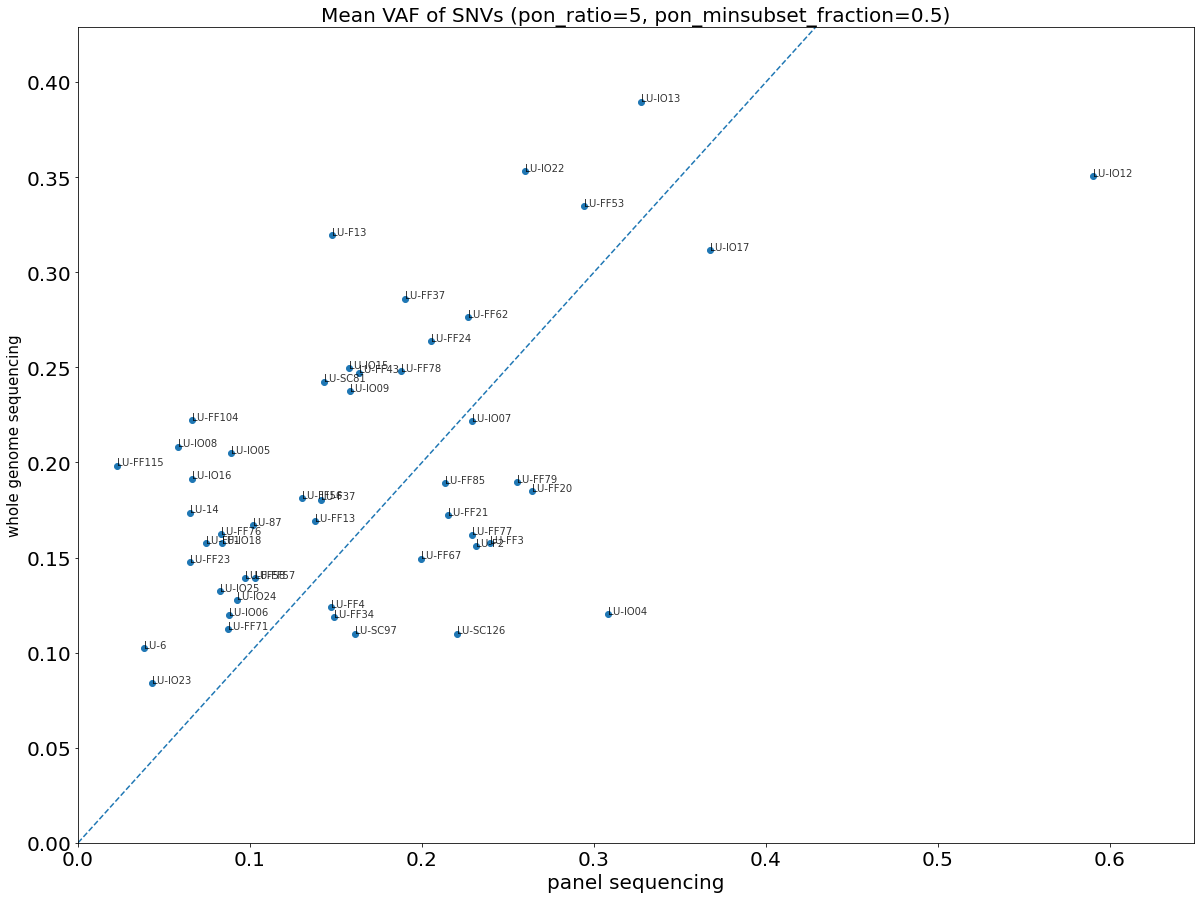

In [559]:
previous_sampleids = [x for x in SAMPLEIDS_LU if x in previous_wgs_vafs]
x = [np.mean(panel_vafs[sampleid]) for sampleid in previous_sampleids]
y = [np.mean(previous_wgs_vafs[sampleid]) for sampleid in previous_sampleids]
labels = previous_sampleids

logscale = False

fig, ax = plt.subplots(figsize=(20, 15))

# labels
ax.set_title(f'Mean VAF of SNVs (pon_ratio={pon_ratio}, pon_minsubset_fraction={pon_minsubset_fraction})', fontsize=20)
ax.set_xlabel('panel sequencing', fontsize=20)
ax.set_ylabel('whole genome sequencing', fontsize=15)
ax.tick_params('x', labelsize=20)
ax.tick_params('y', labelsize=20)

# xlim, ylim
ax.set_xlim(0, max(x) * 1.1)
# ax.set_xlim(0, 20)
if not logscale:
    ax.set_ylim(0, max(y) * 1.1)
# ax.set_ylim(0, 50000)

# logscale y
if logscale:
    ax.set_yscale('log')

# scatterplot
ax.scatter(x, y)

# text annotation
for idx, text in enumerate(labels):
    ax.annotate(text, (x[idx], y[idx]), fontsize=10, alpha=0.8)

# abline
ax_xlim_min, ax_xlim_max = ax.get_xlim()
# if ax_xlim_min == 0:
#     ax_xlim_min = 1
line_xvals = np.linspace(ax_xlim_min, ax_xlim_max, 100)
line_yvals = 1 * line_xvals
ax.plot(line_xvals, line_yvals, '--')
